# Часть 6. Дополнительные признаки.

In [1]:
import numpy as np
import pandas as pd
import datetime
import os
import holidays
import warnings
import requests
import time
import json
import pytz
import xgboost as xgb
import tensorflow as tf
import folium

from joblib import dump, load
from itertools import product
from matplotlib import pyplot as plt
from matplotlib import image as pltimg
from matplotlib import colors
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn import model_selection, linear_model, metrics, preprocessing
from scipy import stats as sts
from itertools import product

## 6.1. Ошибка в мае 16-го на обученных в прошлом разделе моделях.

<dl>
<dd>Использовались следующие признаки:</dd>
<dd>&nbsp; &nbsp; &nbsp; &nbsp; идентификатор кластера - категориальный признак;</dd>
<dd>&nbsp; &nbsp; &nbsp; &nbsp; год - вещественный, месяц, день недели, час - категориальные;</dd>
<dd>&nbsp; &nbsp; &nbsp; &nbsp; синусы и косинусы по периодами годовой и недельной сезонности;</dd>
<dd>&nbsp; &nbsp; &nbsp; &nbsp; количество поездок из рассматриваемого района в моменты времени $y_T, y_{T-1}...y_{T-K}$;</dd>
<dd>&nbsp; &nbsp; &nbsp; &nbsp; количество поездок из рассматриваемого района в моменты времени $y_{T-24}, y_{T-48}...y_{T-24*K_d}$;</dd>    
<dd>&nbsp; &nbsp; &nbsp; &nbsp; суммарное количество поездок из рассматриваемого района за предшествующие полдня, сутки, неделю, месяц.</dd>    
</dl>

In [3]:
warnings.filterwarnings('ignore')
train_data = np.load('old_samples/train_data.npy')
test_data = np.load('old_samples/test_data.npy')
best_xgb_params = load('old_dumps/best_xgb_params.joblib')
ERR = 0
for i in range(1, 7):
    train_labels = np.load('old_samples/train_labels_{}.npy'.format(i))
    test_labels = np.load('old_samples/test_labels_{}.npy'.format(i))
    
    xgb_model = xgb.XGBRegressor(learning_rate=best_xgb_params[0], n_estimators=best_xgb_params[1], 
                             reg_lambda=best_xgb_params[2], reg_alpha=best_xgb_params[3], n_jobs=-1)  

    
    xgb_model.fit(train_data, train_labels)
    pred = xgb_model.predict(test_data)
    ERR += metrics.mean_absolute_error(test_labels, pred)
    
print('Ошибка на майских данных - {:.3f}'.format(ERR/6))
warnings.filterwarnings('default')

[16:43:01] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:45:14] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:47:22] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:49:31] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:51:36] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:53:52] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Ошибка на майских данных - 26.588


## 6.2. Усовершенствование применённых признаков.

Сперва более точно настроим уже применённые признаки.

### 6.2.1. Идентификатор кластера.

Оставим без изменений.

In [2]:
def get_cluster_features(cell_data, region_number):
    cluster = reg_info[reg_info.region==region_number].cluster.values[0]
    vals = np.array([cluster for _ in range(cell_data.shape[0])] + [i for i in range(5)])
    vals = OneHotEncoder(sparse=False).fit_transform(vals.reshape(-1, 1))[:-5, :]
    cluster_names = ['cluster_{}'.format(i) for i in range(5)]
    for i in range(len(cluster_names)):
        cell_data[cluster_names[i]] = vals[:, i]
    return cluster_names 

### 6.2.2. Месяц, день недели, час.

Без изменений.

In [3]:
# Год.
def get_year(cell_data):
    cell_data['year'] = np.array([i.year for i in cell_data.index])
    return ['year']

In [4]:
# Месяц, день недели, час.
def get_date_features(cell_data):
    
    # Месяц.
    months_names = ['january', 'february', 'march', 'april', 'may', 'june', 
                'jule', 'august', 'september', 'october', 'november', 'december']
    months = np.array([i.month for i in cell_data.index] + list(range(1, 13)))
    res = OneHotEncoder(sparse=False).fit_transform(months.reshape((-1,1)))[:-12, :]
    for i in range(len(months_names)):
        cell_data[months_names[i]] = res[:, i]
    dates_names = months_names
    
    # День недели.
    weekdays = ['monday', 'tuesday', 'wednesday', 'thursday', 'friday', 'saturday', 'sunday']
    days = cell_data.index
    days = np.array([i.weekday() + 1 for i in days] + list(range(1, 8)))
    res = OneHotEncoder(sparse=False).fit_transform(days.reshape((-1,1)))[:-7, :]
    for i in range(len(weekdays)):
        cell_data[weekdays[i]] = res[:, i]
    dates_names += weekdays
    
    # Час.
    hour_names = ['{}h'.format(i) for i in range(24)]
    hours = cell_data.index
    hours = np.array([i.hour for i in hours] + list(range(24)))
    res = OneHotEncoder(sparse=False).fit_transform(hours.reshape((-1,1)))[:-24, :]
    for i in range(len(hour_names)):
        cell_data[hour_names[i]] = res[:, i]
    dates_names += hour_names
    
    return dates_names

### 6.2.3. Синусы и косинусы.

По ячейке, рассмотренной в разделе 3 (Empire Sate Building) с помощью обычной линейной регрессии подберем количество признаков для недельной (K_WEEK), и для годовой (K_YEAR) сезонности, которые лучше других описывают данные в апреле 16-го.

In [5]:
data = pd.read_csv('all_count.csv', sep=',', header=0, parse_dates=True,
                   date_parser = lambda x: datetime.datetime.strptime(x, '%Y-%m-%d %H:%M:%S'))
data.columns = list(data.columns[:5]) + [datetime.datetime.strptime(i, '%Y-%m-%d %H:%M:%S') for i in data.columns[5:]]

In [7]:
data.head()

,region,west,east,south,north,2014-05-01 00:00:00,2014-05-01 01:00:00,2014-05-01 02:00:00,2014-05-01 03:00:00,2014-05-01 04:00:00,...,2016-06-30 14:00:00,2016-06-30 15:00:00,2016-06-30 16:00:00,2016-06-30 17:00:00,2016-06-30 18:00:00,2016-06-30 19:00:00,2016-06-30 20:00:00,2016-06-30 21:00:00,2016-06-30 22:00:00,2016-06-30 23:00:00
0,1075,-74.022246,-74.011135,40.697437,40.705825,36.0,19.0,9.0,2.0,7.0,...,109.0,86.0,81.0,82.0,88.0,116.0,104.0,151.0,106.0,85.0
1,1076,-74.022246,-74.011135,40.705825,40.714213,52.0,34.0,16.0,7.0,9.0,...,236.0,199.0,152.0,139.0,173.0,190.0,142.0,162.0,168.0,130.0
2,1077,-74.022246,-74.011135,40.714213,40.722601,41.0,25.0,13.0,2.0,4.0,...,103.0,68.0,85.0,100.0,117.0,135.0,149.0,145.0,103.0,86.0
3,1125,-74.011135,-74.000023,40.697437,40.705825,56.0,27.0,17.0,4.0,11.0,...,107.0,78.0,86.0,80.0,75.0,132.0,141.0,135.0,125.0,113.0
4,1126,-74.011135,-74.000023,40.705825,40.714213,174.0,83.0,56.0,36.0,37.0,...,212.0,213.0,179.0,255.0,309.0,395.0,333.0,359.0,317.0,256.0


In [8]:
# Координаты Empire State Building.
longitude = -73.985428
latitude = 40.748817

# Ищем ячейку
cell_data = data[(data.west <= longitude) & 
           (data.east >= longitude) & 
           (data.south <= latitude) & 
           (data.north >= latitude)]
cell_data = cell_data.iloc[:, 5:-720].transpose()
cell_data.columns = ['trips']
cell_data.tail()

,trips
2016-05-31 19:00:00,1094.0
2016-05-31 20:00:00,997.0
2016-05-31 21:00:00,1099.0
2016-05-31 22:00:00,874.0
2016-05-31 23:00:00,608.0


In [5]:
# Синусы и косинусы.
def add_trig_features(cell_data, k_week, k_year, counter=1):
    
    cell_data['const'] = 1
    cell_data['lin'] = np.arange(counter, cell_data.shape[0]+counter)
    features = []
    for i in range(1, k_week+1):
        week_sin_col = 'week_sin_{}'.format(i)
        week_cos_col = 'week_cos_{}'.format(i)
        
        cell_data[week_sin_col] = np.sin(np.array(cell_data['lin'] * 2 * np.pi * i / 168))
        cell_data[week_cos_col] = np.cos(np.array(cell_data['lin'] * 2 * np.pi * i / 168))
        
        features += [week_sin_col, week_cos_col]
    for i in range(1, k_year+1):
        year_sin_col = 'year_sin_{}'.format(i)
        year_cos_col = 'year_cos_{}'.format(i)
        
        cell_data[year_sin_col] = np.sin(np.array(cell_data['lin'] * 2 * np.pi * i / 8766))
        cell_data[year_cos_col] = np.cos(np.array(cell_data['lin'] * 2 * np.pi * i / 8766))
        
        features += [year_sin_col, year_cos_col]
    
    cell_data.drop(columns=['const', 'lin'], inplace=True)
    
    return features      

In [8]:
k_ws = list(range(5, 101, 5))
k_ys = list(range(2, 51, 5))
ks = list(product(k_ws, k_ys))
len(ks)

200

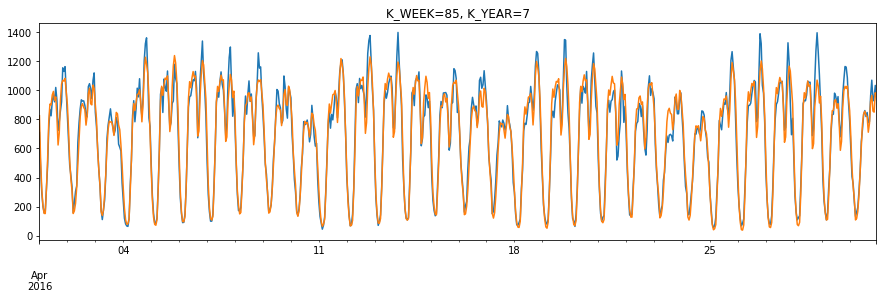

In [85]:
warnings.filterwarnings('ignore')
best_err = float('inf')
march_data = cell_data.loc[:datetime.datetime(2016, 3, 31, 23)]
apr_data = cell_data.loc[datetime.datetime(2016, 4, 1, 0):datetime.datetime(2016, 4, 30, 23)]
train_labels = np.array(march_data['trips'])
test_labels = np.array(apr_data['trips'])
for i in range(len(ks)):
    k_week = ks[i][0]
    k_year = ks[i][1]
    os.write(1, (str(i+1)+'\n').encode())
    features = add_trig_features(march_data, k_week, k_year)
    train_data = np.array(march_data[features])
    _ = add_trig_features(apr_data, k_week, k_year, counter=train_data.shape[0]+1)
    test_data = np.array(apr_data[features])
    model = linear_model.LinearRegression()
    try:
        model.fit(train_data, train_labels)
    except np.linalg.LinAlgError or np.linalg.linalg.LinAlgError:
        continue
    pred = model.predict(test_data)
    err = metrics.mean_absolute_error(test_labels, pred)
    if err < best_err:
        best_err = err
        best_k_week = k_week
        best_k_year = k_year
        apr_data['pred'] = pred

fig, ax = plt.subplots(figsize=(15,4))
apr_data['trips'].plot(ax=ax)
apr_data['pred'].plot(ax=ax)
ax.set_title('K_WEEK={}, K_YEAR={}'.format(best_k_week, best_k_year, fontsize=20, y=1.01))
plt.show()
warnings.filterwarnings('default')

### 6.2.4. Количество поездок из рассматриваемого района в моменты времени $y_T, y_{T-1}...y_{T-K_h} ...y_{T-24*K_d}, y_{T-24*K_d-1}...y_{T-24*K_d-K_h}$

Объединим два признака. Будем делать по аналогии с обычными и сезонными лагами частичной автокорелляции. 

In [6]:
def get_hour_day_lags(cell_data, k_day, k_hour):
    features = []
    for day in range(k_day+1):
        for hour in range(k_hour+1):
            feature = 'lag_d{}_h{}'.format(day, hour)
            features.append(feature)
            ind = 24*day + hour
            cell_data[feature] = cell_data['trips'].shift(ind)
    return features

Подберем такие K_DAY и K_HOUR, которые лучше всего описывают остатки регрессии при назначенных K_WEEK и K_YEAR в апреле 16-го.

In [12]:
# Координаты Empire State Building.
longitude = -73.985428
latitude = 40.748817

# Ищем ячейку
cell_data = data[(data.west <= longitude) & 
           (data.east >= longitude) & 
           (data.south <= latitude) & 
           (data.north >= latitude)]
cell_data = cell_data.iloc[:, 5:-720].transpose()
cell_data.columns = ['trips']

# Получим остатки регрессии.
K_WEEK = 85
K_YEAR = 7
cell_data = cell_data.loc[:datetime.datetime(2016, 4, 30, 23)]
features = add_trig_features(cell_data, K_WEEK, K_YEAR)
model = linear_model.LinearRegression()
model.fit(np.array(cell_data[features]), np.array(cell_data['trips']))
cell_data['reg_resid'] = np.array(cell_data['trips']) - model.predict(np.array(cell_data[features]))

In [13]:
plot_data = pd.DataFrame(cell_data.loc[datetime.datetime(2016, 4, 1, 0):datetime.datetime(2016, 4, 30, 23)]['reg_resid'])
plot_data.head()

,reg_resid
2016-04-01 00:00:00,-109.885536
2016-04-01 01:00:00,-53.522408
2016-04-01 02:00:00,-20.200226
2016-04-01 03:00:00,-4.335793
2016-04-01 04:00:00,4.119385


In [104]:
days = list(range(7))
hours = list(range(24))
params = list(product(days, hours))
len(params)

168

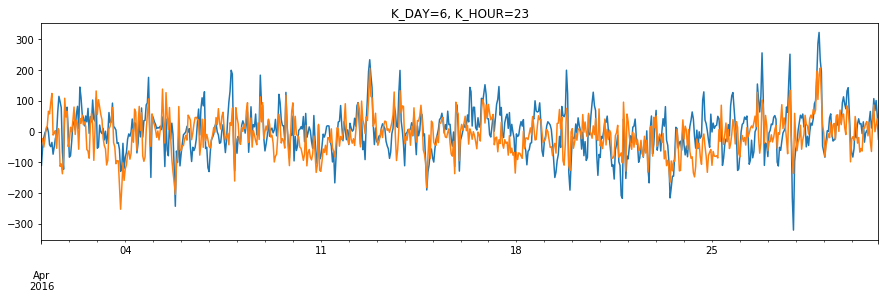

In [105]:
warnings.filterwarnings('ignore')
best_err = float('inf')
for i in range(len(params)):
    k_day = params[i][0]
    k_hour = params[i][1]
    os.write(1, (str(i+1)+'\n').encode())
    
    features = get_hour_day_lags(cell_data, k_day, k_hour)
    temp_data = cell_data.dropna()
    march_data = temp_data.loc[:datetime.datetime(2016, 3, 31, 23)]
    apr_data = temp_data.loc[datetime.datetime(2016, 4, 1, 0):datetime.datetime(2016, 4, 30, 23)]
    train_data = np.array(march_data[features])
    train_labels = np.array(march_data['reg_resid'])
    test_data = np.array(apr_data[features])
    test_labels = np.array(apr_data['reg_resid'])

    model = linear_model.LinearRegression()
    try:
        model.fit(train_data, train_labels)
    except np.linalg.LinAlgError or np.linalg.linalg.LinAlgError:
        continue
    pred = model.predict(test_data)
    err = metrics.mean_absolute_error(test_labels, pred)
    if err < best_err:
        best_err = err
        best_k_day = k_day
        best_k_hour = k_hour
        plot_data['pred'] = pred

fig, ax = plt.subplots(figsize=(15,4))
plot_data['reg_resid'].plot(ax=ax)
plot_data['pred'].plot(ax=ax)
ax.set_title('K_DAY={}, K_HOUR={}'.format(best_k_day, best_k_hour, fontsize=20, y=1.01))
plt.show()
warnings.filterwarnings('default')

### 6.2.5. Cуммарное количество поездок из рассматриваемого района за предшествующие полдня, сутки, неделю, месяц.

Без изменений.

In [7]:
def get_past_sums(cell_data):
    cell_data['half_day_sum'] = cell_data.trips.rolling(12).sum()
    cell_data['half_day_sum'] = cell_data['half_day_sum'].shift(1)
    cell_data['full_day_sum'] = cell_data.trips.rolling(24).sum()
    cell_data['full_day_sum'] = cell_data['full_day_sum'].shift(1)
    cell_data['week_sum'] = cell_data.trips.rolling(168).sum()
    cell_data['week_sum'] = cell_data['week_sum'].shift(1)
    cell_data['month_sum'] = cell_data.trips.rolling(30*24).sum()
    cell_data['month_sum'] = cell_data['month_sum'].shift(1)
    return ['half_day_sum', 'full_day_sum', 'week_sum', 'month_sum']

## 6.3. Аггрегация дополнительных данных.

<dl>
<dd>Нам понадобятся следующие данные:</dd>
<dd>&nbsp; &nbsp; &nbsp; &nbsp; список соседних зон;</dd>
<dd>&nbsp; &nbsp; &nbsp; &nbsp; площадь зон;</dd>
<dd>&nbsp; &nbsp; &nbsp; &nbsp; количество поездок в регионы;</dd>
<dd>&nbsp; &nbsp; &nbsp; &nbsp; среднее количество пассажиров в поездках в регион;</dd>
<dd>&nbsp; &nbsp; &nbsp; &nbsp; среднее количество пассажиров в поездках из региона;</dd>
<dd>&nbsp; &nbsp; &nbsp; &nbsp; среднее расстояние поездок в регион;</dd>
<dd>&nbsp; &nbsp; &nbsp; &nbsp; среднее расстояние поездок из региона;</dd>
<dd>&nbsp; &nbsp; &nbsp; &nbsp; данные о погоде.</dd>

### 6.3.1. Cписок соседних регионов.

In [314]:
reg_info = pd.read_csv('reg_info.csv', sep=',', header=0)
reg_info['neighbors'] = np.nan
reg_info.head()

,region,west,east,south,north,cluster,neighbors,square
0,1075,-74.022246,-74.011135,40.697437,40.705825,1,NaN,0.000093
1,1076,-74.022246,-74.011135,40.705825,40.714213,0,NaN,0.000093
2,1077,-74.022246,-74.011135,40.714213,40.722601,0,NaN,0.000093
3,1125,-74.011135,-74.000023,40.697437,40.705825,1,NaN,0.000093
4,1126,-74.011135,-74.000023,40.705825,40.714213,1,NaN,0.000093


In [319]:
neighbors = []
for ind, row in reg_info.iterrows():
    now_neighbors = []
    west = row.west
    east = row.east
    south = row.south
    north = row.north
    
    left_low = (west, south)
    left_up = (west, north)
    right_low = (east, south)
    right_up = (east, north)    
    
    points = {left_low, left_up, right_low, right_up}
    
    for _, neigh_row in reg_info.iterrows():
        if row.region == neigh_row.region:
            continue
        neigh_west = neigh_row.west
        neigh_east = neigh_row.east
        neigh_south = neigh_row.south
        neigh_north = neigh_row.north
        
        neigh_left_low = (neigh_west, neigh_south)
        neigh_left_up = (neigh_west, neigh_north)
        neigh_right_low = (neigh_east, neigh_south)
        neigh_right_up = (neigh_east, neigh_north)    
        
        neigh_points = {neigh_left_low, neigh_left_up, neigh_right_low, neigh_right_up}
        
        if len(points.intersection(neigh_points)) and (int(neigh_row.region) in list(reg_info.region)) > 0:
            now_neighbors.append(int(neigh_row.region))
    neighbors.append(now_neighbors)
neighbors = np.array(neighbors)
reg_info['neighbors'] = neighbors
reg_info.to_csv('reg_info.csv', sep=',', header=True, index=False)
reg_info.head()

,region,west,east,south,north,cluster,neighbors,square
0,1075,-74.022246,-74.011135,40.697437,40.705825,1,"[1076, 1125, 1126]",0.000093
1,1076,-74.022246,-74.011135,40.705825,40.714213,0,"[1075, 1077, 1125, 1126, 1127]",0.000093
2,1077,-74.022246,-74.011135,40.714213,40.722601,0,"[1076, 1126, 1127, 1128]",0.000093
3,1125,-74.011135,-74.000023,40.697437,40.705825,1,"[1075, 1076, 1126, 1174, 1175, 1176]",0.000093
4,1126,-74.011135,-74.000023,40.705825,40.714213,1,"[1075, 1076, 1077, 1125, 1127, 1175, 1176, 1177]",0.000093


### 6.3.2. Площадь регионов.

In [320]:
reg_info = pd.read_csv('reg_info.csv', sep=',', header=0)
reg_info['square'] = np.nan
reg_info.head()

,region,west,east,south,north,cluster,neighbors,square
0,1075,-74.022246,-74.011135,40.697437,40.705825,1,"[1076, 1125, 1126]",NaN
1,1076,-74.022246,-74.011135,40.705825,40.714213,0,"[1075, 1077, 1125, 1126, 1127]",NaN
2,1077,-74.022246,-74.011135,40.714213,40.722601,0,"[1076, 1126, 1127, 1128]",NaN
3,1125,-74.011135,-74.000023,40.697437,40.705825,1,"[1075, 1076, 1126, 1174, 1175, 1176]",NaN
4,1126,-74.011135,-74.000023,40.705825,40.714213,1,"[1075, 1076, 1077, 1125, 1127, 1175, 1176, 1177]",NaN


In [321]:
squares = []
for _, row in reg_info.iterrows():
    widht = abs(row.west - row.east)
    height = abs(row.north - row.south)
    square = widht * height
    squares.append(square)
squares = np.array(squares)
reg_info['square'] = squares
reg_info.to_csv('reg_info.csv', sep=',', header=True, index=False)
reg_info.head()

,region,west,east,south,north,cluster,neighbors,square
0,1075,-74.022246,-74.011135,40.697437,40.705825,1,"[1076, 1125, 1126]",0.000093
1,1076,-74.022246,-74.011135,40.705825,40.714213,0,"[1075, 1077, 1125, 1126, 1127]",0.000093
2,1077,-74.022246,-74.011135,40.714213,40.722601,0,"[1076, 1126, 1127, 1128]",0.000093
3,1125,-74.011135,-74.000023,40.697437,40.705825,1,"[1075, 1076, 1126, 1174, 1175, 1176]",0.000093
4,1126,-74.011135,-74.000023,40.705825,40.714213,1,"[1075, 1076, 1077, 1125, 1127, 1175, 1176, 1177]",0.000093


### 6.3.3. Количество поездок в регионы, количество пассажиров и дистанция.

In [9]:
# Получение списка количества поездок по координатам.
def get_values(x, y, statistic='count', vals=None):
    west = -74.25559 
    east = -73.70001
    south = 40.49612
    north = 40.91553
    counts = sts.binned_statistic_2d(x, y, vals, statistic=statistic, bins=50, 
                        range=[[west, east], [south, north]])
    return counts.statistic.ravel()

In [10]:
# Генератор часов. Верхняя граница не включается.
def hour_range(start_date, end_date):
    delta = (end_date - start_date).total_seconds() / (60*60)
    for i in range(int(delta)):
        yield start_date + datetime.timedelta(hours=i)

In [10]:
# Считаем поездки в регион. Модифицирует датафрейм.
def gogo(count_data_into, count_pass, count_pass_into, count_dist, count_dist_into, clean_filename, chunksize=1e6):
    hours = [str(i) for i in hour_range(datetime.datetime(2014, 5, 1, 0), datetime.datetime(2016, 7, 1, 0))]
    
    for chunk in pd.read_csv(clean_filename, sep=',', header=0, chunksize=chunksize):
        # Добавляем столбцы часов в датафрейм.
        if count_data_into.shape[1] < 10:
            for hour in hours:
                count_data_into[hour] = 0
                count_pass[hour] = 0
                count_pass_into[hour] = 0
                count_dist[hour] = 0
                count_dist_into[hour] = 0
        
        #Данные на поездках в регионы.
        for hour in chunk['tpep_pickup_datetime'].unique():
            h_chunk = chunk[chunk['tpep_pickup_datetime'] == hour]
            x = np.array(h_chunk['pickup_longitude'])
            y = np.array(h_chunk['pickup_latitude'])
            count_pass[hour] = np.array(count_pass[hour]) + get_values(x, y, 'sum', np.array(h_chunk['passenger_count']))
            count_dist[hour] = np.array(count_dist[hour]) + get_values(x, y, 'sum', np.array(h_chunk['trip_distance']))
        
        # Убираем поездки координатами высадки, не входящими в координаты Нью-Йорка.
        chunk_into = chunk[(chunk['dropoff_longitude'] <= -73.70001) & 
                           (chunk['dropoff_longitude'] >= -74.25559) & 
                           (chunk['dropoff_latitude'] <= 40.91553) & 
                           (chunk['dropoff_latitude'] >= 40.49612)]
        
        # Обнулим минуты и секунды времени высадки.
        chunk_into['tpep_dropoff_datetime'] = chunk_into['tpep_dropoff_datetime'].apply(
            lambda x: datetime.datetime.strptime(x, '%Y-%m-%d %H:%M:%S').replace(minute=0, second=0).strftime('%Y-%m-%d %H:%M:%S'))
        
        # Данные на поездках из регионов.
        for hour in chunk_into['tpep_dropoff_datetime'].unique():
            
            # Данные за июль не учитываем - у нас их нет.
            if hour not in hours:
                continue
                
            h_chunk = chunk_into[chunk_into['tpep_dropoff_datetime'] == hour]
            x = np.array(h_chunk['dropoff_longitude'])
            y = np.array(h_chunk['dropoff_latitude'])
            count_data_into[hour] = np.array(count_data_into[hour]) + get_values(x, y)
            count_pass_into[hour] = np.array(count_pass_into[hour]) + get_values(x, y, 'sum', np.array(h_chunk['passenger_count']))
            count_dist_into[hour] = np.array(count_dist_into[hour]) + get_values(x, y, 'sum', np.array(h_chunk['trip_distance']))

In [25]:
# Файлы с очищенными данными.
dir_with_clean_data = os.path.join(os.path.dirname(os.path.dirname(os.path.abspath('file'))), 'clean_data')
clean_files = os.listdir(dir_with_clean_data)
clean_files.sort()

# Назначим папки для записи.
root_dir = os.path.dirname(os.path.dirname(os.path.abspath('file')))
dir_count_data = os.path.join(root_dir, 'count_data')
dir_count_data_into = os.path.join(root_dir, 'count_data_into')
dir_count_pass = os.path.join(root_dir, 'count_pass')
dir_count_pass_into = os.path.join(root_dir, 'count_pass_into')
dir_count_dist = os.path.join(root_dir, 'count_dist')
dir_count_dist_into = os.path.join(root_dir, 'count_dist_into')

# Регионы.
reg_file = os.path.join(os.path.dirname(os.path.dirname(os.path.abspath('file'))), 'regions.csv')
regions = pd.read_csv(reg_file, sep=';')

In [26]:
# Считаем, записываем.
CHUNKSIZE = 1e6 * 1.5
regs_id = np.array(pd.read_csv('reg_info.csv', sep=',', header=0).region)

for file in clean_files:
    
    print(datetime.datetime.now().strftime('%H:%M'), file)
    
    clean_filename = os.path.join(dir_with_clean_data, file)
    
    count_data_into = regions.copy(deep=True)
    count_pass = regions.copy(deep=True)
    count_pass_into = regions.copy(deep=True)
    count_dist = regions.copy(deep=True)
    count_dist_into = regions.copy(deep=True)
    
    # Имена файлов для записи.
    count_data_filename = os.path.join(dir_count_data, 'count_' + file)
    count_data_into_filename = os.path.join(dir_count_data_into, 'count_' + file)
    count_pass_filename = os.path.join(dir_count_pass, 'count_' + file)
    count_pass_into_filename = os.path.join(dir_count_pass_into, 'count_' + file)
    count_dist_filename = os.path.join(dir_count_dist, 'count_' + file)
    count_dist_into_filename = os.path.join(dir_count_dist_into, 'count_' + file)

    # Считаем.
    gogo(count_data_into, count_pass, count_pass_into, count_dist, count_dist_into, clean_filename, CHUNKSIZE)
    
    # Убираем лишние регионы. Высчитываем средние значения.
    count_data_into = count_data_into[count_data_into.region.isin(regs_id)]
    count_pass = count_pass[count_pass.region.isin(regs_id)]
    count_pass_into = count_pass_into[count_pass_into.region.isin(regs_id)]
    count_dist = count_dist[count_dist.region.isin(regs_id)]
    count_dist_into = count_dist_into[count_dist_into.region.isin(regs_id)]
    
    # Записываем.
    count_data_into.to_csv(count_data_into_filename, sep=',', header=True, index=False)
    count_pass.to_csv(count_pass_filename, sep=',', header=True, index=False)
    count_pass_into.to_csv(count_pass_into_filename, sep=',', header=True, index=False)
    count_dist.to_csv(count_dist_filename, sep=',', header=True, index=False)
    count_dist_into.to_csv(count_dist_into_filename, sep=',', header=True, index=False)

23:51 cleaned_yellow_tripdata_2014-05.csv


D:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


00:40 cleaned_yellow_tripdata_2014-06.csv
01:22 cleaned_yellow_tripdata_2014-07.csv


D:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3214: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  if (yield from self.run_code(code, result)):


02:00 cleaned_yellow_tripdata_2014-08.csv
02:40 cleaned_yellow_tripdata_2014-09.csv
03:20 cleaned_yellow_tripdata_2014-10.csv
04:01 cleaned_yellow_tripdata_2014-11.csv
04:52 cleaned_yellow_tripdata_2014-12.csv
05:30 cleaned_yellow_tripdata_2015-01.csv
06:30 cleaned_yellow_tripdata_2015-02.csv
07:21 cleaned_yellow_tripdata_2015-03.csv
08:20 cleaned_yellow_tripdata_2015-04.csv
09:15 cleaned_yellow_tripdata_2015-05.csv
10:20 cleaned_yellow_tripdata_2015-06.csv
10:51 cleaned_yellow_tripdata_2015-07.csv
11:22 cleaned_yellow_tripdata_2015-08.csv
11:53 cleaned_yellow_tripdata_2015-09.csv
12:24 cleaned_yellow_tripdata_2015-10.csv
12:56 cleaned_yellow_tripdata_2015-11.csv
13:27 cleaned_yellow_tripdata_2015-12.csv
13:57 cleaned_yellow_tripdata_2016-01.csv
14:29 cleaned_yellow_tripdata_2016-02.csv
15:00 cleaned_yellow_tripdata_2016-03.csv
15:48 cleaned_yellow_tripdata_2016-04.csv
16:19 cleaned_yellow_tripdata_2016-05.csv
16:51 cleaned_yellow_tripdata_2016-06.csv


### 6.3.4. Аггрегация пассажиров и расстояний.

In [27]:
# Файлы с очищенными данными.
dir_with_clean_data = os.path.join(os.path.dirname(os.path.dirname(os.path.abspath('file'))), 'clean_data')
clean_files = os.listdir(dir_with_clean_data)
clean_files.sort()

# Назначим папки для записи.
root_dir = os.path.dirname(os.path.dirname(os.path.abspath('file')))
dir_count_data = os.path.join(root_dir, 'count_data')
dir_count_data_into = os.path.join(root_dir, 'count_data_into')
dir_count_pass = os.path.join(root_dir, 'count_pass')
dir_count_pass_into = os.path.join(root_dir, 'count_pass_into')
dir_count_dist = os.path.join(root_dir, 'count_dist')
dir_count_dist_into = os.path.join(root_dir, 'count_dist_into')

In [13]:
# Склеиваем датафреймы.
def glue(directory):
    
    print(directory, '...', datetime.datetime.now(), end='...')
    
    hours = [str(i) for i in hour_range(datetime.datetime(2014, 5, 1, 0), datetime.datetime(2016, 7, 1, 0))]
    files = os.listdir(directory)
    files.sort()
    
    data = None
    for file in files:
        filename = os.path.join(directory, file)
        if data is None:
            data = pd.read_csv(filename, sep=',', header=0)
            continue
        add_data = pd.read_csv(filename, sep=',', header=0)
        for col in data.columns[5:]:
            data[col] = data[col] + add_data[col]
    
    return data

In [29]:
all_count = pd.read_csv('all_count.csv', sep=',', header=0)

all_count_into = glue(dir_count_data_into)
check_data = np.array(all_count_into.iloc[:, 5:])
if not check_data.sum():
    print('ALL COUNT ZERO!!!')
else:
    print('CHECK')    
all_count_into.to_csv('all_count_into.csv', sep=',', header=True, index=False)


pass_count = glue(dir_count_pass)
pass_count[pass_count.columns[5:]] = pass_count.iloc[:, 5:] / all_count.iloc[:, 5:]
check_data = np.array(pass_count.iloc[:, 5:])
if np.isnan(check_data).sum() or np.isinf(check_data).sum():
    print('INF OR NAN')
else:
    print('CHECK')    
pass_count.to_csv('pass_count.csv', sep=',', header=True, index=False)


pass_count_into = glue(dir_count_pass_into)
pass_count_into[pass_count_into.columns[5:]] = pass_count_into.iloc[:, 5:] / all_count_into.iloc[:, 5:]
check_data = np.array(pass_count_into.iloc[:, 5:])
if np.isnan(check_data).sum() or np.isinf(check_data).sum():
    print('INF OR NAN')
else:
    print('CHECK')    
pass_count_into.to_csv('pass_count_into.csv', sep=',', header=True, index=False)

dist_count = glue(dir_count_dist)
dist_count[dist_count.columns[5:]] = dist_count.iloc[:, 5:] / all_count.iloc[:, 5:]
check_data = np.array(dist_count.iloc[:, 5:])
if np.isnan(check_data).sum() or np.isinf(check_data).sum():
    print('INF OR NAN')
else:
    print('CHECK')    
dist_count.to_csv('dist_count.csv', sep=',', header=True, index=False)

dist_count_into = glue(dir_count_dist_into)
dist_count_into[dist_count_into.columns[5:]] = dist_count_into.iloc[:, 5:] / all_count_into.iloc[:, 5:]
check_data = np.array(dist_count_into.iloc[:, 5:])
if np.isnan(check_data).sum() or np.isinf(check_data).sum():
    print('INF OR NAN')
else:
    print('CHECK')    
dist_count_into.to_csv('dist_count_into.csv', sep=',', header=True, index=False)

F:\for week_6\count_data_into ... 2019-06-09 17:22:04.614423...CHECK
F:\for week_6\count_pass ... 2019-06-09 17:27:47.983467...INF OR NAN
F:\for week_6\count_pass_into ... 2019-06-09 17:33:32.936277...INF OR NAN
F:\for week_6\count_dist ... 2019-06-09 17:39:20.061186...INF OR NAN
F:\for week_6\count_dist_into ... 2019-06-09 17:45:07.831420...INF OR NAN


Уберем пропущенные значения. Они получились из-за деления ноль на ноль при поиске среднего.

Pass count.

In [50]:
pass_count = pd.read_csv('pass_count.csv')
pass_count.fillna(0, inplace=True)
print(pass_count.shape)
pass_count.head()

(102, 19013)


,region,west,east,south,north,2014-05-01 00:00:00,2014-05-01 01:00:00,2014-05-01 02:00:00,2014-05-01 03:00:00,2014-05-01 04:00:00,...,2016-06-30 14:00:00,2016-06-30 15:00:00,2016-06-30 16:00:00,2016-06-30 17:00:00,2016-06-30 18:00:00,2016-06-30 19:00:00,2016-06-30 20:00:00,2016-06-30 21:00:00,2016-06-30 22:00:00,2016-06-30 23:00:00
0,1075,-74.022246,-74.011135,40.697437,40.705825,1.472222,1.421053,2.333333,1.500000,1.857143,...,1.706422,1.895349,1.975309,1.878049,1.579545,1.439655,1.567308,1.529801,1.594340,1.505882
1,1076,-74.022246,-74.011135,40.705825,40.714213,1.576923,1.764706,1.562500,1.142857,1.555556,...,1.771186,1.723618,1.605263,1.654676,1.676301,1.642105,1.661972,1.524691,1.541667,1.453846
2,1077,-74.022246,-74.011135,40.714213,40.722601,1.609756,1.200000,2.000000,1.500000,1.250000,...,1.766990,1.661765,1.647059,1.830000,1.623932,1.755556,1.671141,1.641379,1.601942,1.604651
3,1125,-74.011135,-74.000023,40.697437,40.705825,1.714286,1.925926,1.529412,1.000000,2.909091,...,1.710280,1.717949,1.813953,1.462500,1.466667,1.530303,1.503546,1.577778,1.640000,1.672566
4,1126,-74.011135,-74.000023,40.705825,40.714213,1.649425,1.783133,1.428571,1.555556,2.135135,...,1.759434,1.600939,1.636872,1.627451,1.582524,1.650633,1.522523,1.665738,1.589905,1.507812


In [53]:
pass_count.to_csv('pass_count.csv', sep=',', header=True, index=False)

Pass count into.

In [54]:
pass_count_into = pd.read_csv('pass_count_into.csv')
pass_count_into.fillna(0, inplace=True)
print(pass_count_into.shape)
pass_count_into.head()

(102, 19013)


,region,west,east,south,north,2014-05-01 00:00:00,2014-05-01 01:00:00,2014-05-01 02:00:00,2014-05-01 03:00:00,2014-05-01 04:00:00,...,2016-06-30 14:00:00,2016-06-30 15:00:00,2016-06-30 16:00:00,2016-06-30 17:00:00,2016-06-30 18:00:00,2016-06-30 19:00:00,2016-06-30 20:00:00,2016-06-30 21:00:00,2016-06-30 22:00:00,2016-06-30 23:00:00
0,1075,-74.022246,-74.011135,40.697437,40.705825,1.794118,1.628571,1.882353,1.538462,2.444444,...,1.784314,1.743590,2.178571,2.060000,1.855072,1.284091,1.489362,1.620253,1.587302,1.477273
1,1076,-74.022246,-74.011135,40.705825,40.714213,1.552632,1.758065,1.666667,1.750000,1.400000,...,1.743590,1.656489,1.747253,1.644444,1.610619,1.581560,1.666667,1.686047,1.532609,1.607735
2,1077,-74.022246,-74.011135,40.714213,40.722601,1.488372,1.791667,1.181818,2.000000,1.111111,...,1.523810,1.613636,1.526316,1.966102,1.527473,1.637681,1.722222,1.604396,1.511111,1.637500
3,1125,-74.011135,-74.000023,40.697437,40.705825,1.705882,1.534884,1.173913,1.000000,1.950000,...,1.557143,1.581395,1.921569,1.825000,1.468085,1.471264,1.675000,1.518987,1.461538,1.610526
4,1126,-74.011135,-74.000023,40.705825,40.714213,1.630952,1.697479,1.482759,1.574468,1.523810,...,1.637306,1.568750,1.740000,1.591304,1.523490,1.753846,1.622881,1.612903,1.626866,1.682171


In [57]:
pass_count_into.to_csv('pass_count_into.csv', sep=',', header=True, index=False)

Dist count.

In [58]:
dist_count = pd.read_csv('dist_count.csv')
dist_count.fillna(0, inplace=True)
print(dist_count.shape)
dist_count.head()

(102, 19013)


,region,west,east,south,north,2014-05-01 00:00:00,2014-05-01 01:00:00,2014-05-01 02:00:00,2014-05-01 03:00:00,2014-05-01 04:00:00,...,2016-06-30 14:00:00,2016-06-30 15:00:00,2016-06-30 16:00:00,2016-06-30 17:00:00,2016-06-30 18:00:00,2016-06-30 19:00:00,2016-06-30 20:00:00,2016-06-30 21:00:00,2016-06-30 22:00:00,2016-06-30 23:00:00
0,1075,-74.022246,-74.011135,40.697437,40.705825,4.530833,5.654737,7.126667,11.445000,10.107143,...,4.501376,4.341744,5.096667,5.180610,4.627955,4.020431,4.463173,4.939801,5.347358,5.496235
1,1076,-74.022246,-74.011135,40.705825,40.714213,4.796346,5.490882,6.297500,4.512857,3.886667,...,5.011780,4.925126,4.896645,4.368489,3.878844,3.772316,3.662254,4.334506,4.587381,4.128385
2,1077,-74.022246,-74.011135,40.714213,40.722601,4.667805,3.970000,4.548462,5.115000,7.510000,...,4.472913,3.891618,4.467412,4.149000,4.340513,3.054667,3.442416,4.384345,3.918641,4.237093
3,1125,-74.011135,-74.000023,40.697437,40.705825,4.703750,4.347037,4.047647,4.085000,5.710000,...,5.530748,5.881410,5.325581,5.661250,5.389600,4.172500,4.331915,4.042074,4.627760,5.152566
4,1126,-74.011135,-74.000023,40.705825,40.714213,4.982011,5.521325,5.513214,4.569722,5.660270,...,3.798160,4.551643,4.289162,3.958078,3.630615,3.741544,3.796877,4.087298,4.418959,4.412500


In [60]:
dist_count.to_csv('dist_count.csv', sep=',', header=True, index=False)

Dist count into.

In [61]:
dist_count_into = pd.read_csv('dist_count_into.csv')
dist_count_into.fillna(0, inplace=True)
print(dist_count_into.shape)
dist_count_into.head()

(102, 19013)


,region,west,east,south,north,2014-05-01 00:00:00,2014-05-01 01:00:00,2014-05-01 02:00:00,2014-05-01 03:00:00,2014-05-01 04:00:00,...,2016-06-30 14:00:00,2016-06-30 15:00:00,2016-06-30 16:00:00,2016-06-30 17:00:00,2016-06-30 18:00:00,2016-06-30 19:00:00,2016-06-30 20:00:00,2016-06-30 21:00:00,2016-06-30 22:00:00,2016-06-30 23:00:00
0,1075,-74.022246,-74.011135,40.697437,40.705825,4.119706,5.142000,3.377647,3.307692,6.967778,...,3.909902,4.226923,5.193214,4.023600,4.251884,4.040909,3.769574,3.806709,4.627937,4.884773
1,1076,-74.022246,-74.011135,40.705825,40.714213,3.690263,4.719194,5.190769,5.547500,2.854667,...,3.807846,4.748550,6.544396,4.127111,4.214513,4.628227,3.751429,4.148663,4.303152,4.787624
2,1077,-74.022246,-74.011135,40.714213,40.722601,2.749535,6.411250,3.849091,3.196667,3.796667,...,4.550952,4.335455,3.843789,3.481186,3.702418,3.452464,3.112857,3.936264,4.020000,4.085875
3,1125,-74.011135,-74.000023,40.697437,40.705825,5.321373,5.403023,4.598261,3.883750,3.485500,...,4.393857,3.448837,4.473529,4.271000,5.775957,3.986092,4.543125,4.120759,4.016923,4.217053
4,1126,-74.011135,-74.000023,40.705825,40.714213,3.227679,4.447311,3.717414,3.665106,3.070238,...,3.397461,4.020625,4.250200,4.590957,4.747987,4.097179,3.760381,3.472823,3.602090,3.710930


In [63]:
dist_count_into.to_csv('dist_count_into.csv', sep=',', header=True, index=False)

### 6.3.5. Данные о погоде.

Удалось найти архивные сведения о фактической погоде, а именно прогнозы найти не получилось. Поэтому будем отталкиваться от наблюдаемой погоды в рассматриваемый час, и относительно него делать прогноз о поездках в следующие 6 часов.

API DarkSky

In [25]:
tz = pytz.timezone('America/New_York')

In [87]:
URL = 'https://api.darksky.net/forecast'
KEY = '054cf6d276576a1a728bf5067b94f24b'
NY_COORDINATES = '40.750718,-73.970254'
TIMEZONE = 'America/NY'
URL_PARAMS = 'exclude=daily&units=si'

In [11]:
# Генератор дней. Верхняя граница не входит.
def day_range(start, end):
    for i in range(int((end - start).total_seconds() / (60*60*24))):
        yield start + datetime.timedelta(days=i)

In [99]:
days = [i for i in day_range(datetime.datetime(2014, 5, 1, 12, tzinfo=tz), datetime.datetime(2016, 7, 1, 12, tzinfo=tz))]

In [12]:
def get_url(date):
    str_date = date.strftime('%Y-%m-%dT%H:%M:%S')# + TIMEZONE
    end_req = ','.join([NY_COORDINATES, str_date])
    get_req = '/'.join([URL, KEY, end_req])
    get_req += '?'
    get_req += URL_PARAMS
    return get_req

In [13]:
# Получение ответа. Если не получилось, вернется None.
def get_response(url):
    content = None
    for i in range(5):
        response = requests.get(url)
        if response.ok:
            content = response.content
            break
        else:
            time.sleep(0.1)
    return content  

In [14]:
def get_weather_value(content, key):
    try:
        value = content[key]
    except KeyError:
        value = 'none'
    return value

In [94]:
weather_data = []
columns = ['hour', 'cloud', 'humidity', 'icon', 'nearest_storm_distance', 'precip_intensity', 'precip_type', 
           'temperature', 'visibility', 'wind_gust', 'wind_speed']
for day in days:
    contents = get_response(get_url(day))
    if contents is None:
        print(day, ' NONE!')
        continue
    contents = json.loads(contents.decode())['hourly']['data']
    for content in contents:
        dt = datetime.datetime.fromtimestamp(content['time'], tz=tz).strftime('%Y-%m-%d %H:%M:%S')
        cloud = get_weather_value(content, 'cloudCover') #float
        humidity = get_weather_value(content, 'humidity') #float
        icon = get_weather_value(content, 'icon') #str
        nearest_storm_distance = get_weather_value(content, 'nearestStormDistance') # float
        precip_intensity = get_weather_value(content, 'precipIntensity') #float
        precip_type = get_weather_value(content, 'precipType') #str
        temperature = get_weather_value(content, 'temperature') #float
        visibility = get_weather_value(content, 'visibility') #float
        wind_gust = get_weather_value(content, 'windGust') #float
        wind_speed = get_weather_value(content, 'windSpeed') #float
        weather_data.append([dt, cloud, humidity, icon, nearest_storm_distance, precip_intensity, precip_type, 
                     temperature, visibility, wind_gust, wind_speed])
weather_data = pd.DataFrame(weather_data)
weather_data.to_csv('weather.csv', sep=',', header=True, index=False)
weather_data.columns = columns

In [205]:
weather = pd.read_csv('weather.csv', index_col=0)
print(weather.shape)
weather.head()

(19008, 10)


,cloud,humidity,icon,nearest_storm_distance,precip_intensity,precip_type,temperature,visibility,wind_gust,wind_speed
hour,,,,,,,,,,
2014-05-01 00:00:00,1.0,0.94,rain,none,5.9360,rain,10.40,5.58,3.49,0.99
2014-05-01 01:00:00,1.0,0.93,rain,none,3.8303,rain,11.16,6.90,3.2,0.69
2014-05-01 02:00:00,1.0,0.94,rain,none,1.4097,rain,11.78,4.63,2.85,0.78
2014-05-01 03:00:00,1.0,0.94,rain,none,1.2802,rain,12.26,6.31,3.06,0.96
2014-05-01 04:00:00,1.0,0.95,rain,none,0.4470,rain,12.68,3.75,2.58,0.84


Разделим категориальные признаки, уберем информацию о штормах, т.к. все значения пустые.

In [206]:
weather.icon.unique()

array(['rain', 'fog', 'partly-cloudy-day', 'clear-day',
       'partly-cloudy-night', 'cloudy', 'clear-night', 'snow'],
      dtype=object)

In [207]:
a = OneHotEncoder().fit(np.array(weather.icon).reshape(-1, 1))
cat = [i for i in a.categories_[0]]
vals = a.transform(np.array(weather.icon).reshape(-1, 1)).toarray()
for i in range(len(cat)):
    weather[cat[i]] = vals[:, i]
weather.drop(columns=['icon', 'nearest_storm_distance'], inplace=True)
weather.head(3)

,cloud,humidity,precip_intensity,precip_type,temperature,visibility,wind_gust,wind_speed,clear-day,clear-night,cloudy,fog,partly-cloudy-day,partly-cloudy-night,rain,snow
hour,,,,,,,,,,,,,,,,
2014-05-01 00:00:00,1.0,0.94,5.9360,rain,10.40,5.58,3.49,0.99,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2014-05-01 01:00:00,1.0,0.93,3.8303,rain,11.16,6.90,3.2,0.69,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2014-05-01 02:00:00,1.0,0.94,1.4097,rain,11.78,4.63,2.85,0.78,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [208]:
weather.precip_type.unique()

array(['rain', 'none', 'snow', 'sleet'], dtype=object)

In [13]:
temp = list(weather.wind_gust)
for i in range(len(temp)):
    if temp[i]=='none':
        temp[i] = 0
weather['wind_gust'] = np.array(temp)

In [209]:
a = OneHotEncoder().fit(np.array(weather.precip_type).reshape(-1, 1))
cat = [i + '_intensity' for i in a.categories_[0]]
vals = a.transform(np.array(weather.precip_type).reshape(-1, 1)).toarray()
for i in range(len(cat)):
    weather[cat[i]] = vals[:, i]
    weather[cat[i]] = weather[cat[i]] * weather['precip_intensity']
weather.drop(columns=['precip_type', 'precip_intensity', 'none_intensity'], inplace=True)
weather.head()

,cloud,humidity,temperature,visibility,wind_gust,wind_speed,clear-day,clear-night,cloudy,fog,partly-cloudy-day,partly-cloudy-night,rain,snow,rain_intensity,sleet_intensity,snow_intensity
hour,,,,,,,,,,,,,,,,,
2014-05-01 00:00:00,1.0,0.94,10.40,5.58,3.49,0.99,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,5.9360,0.0,0.0
2014-05-01 01:00:00,1.0,0.93,11.16,6.90,3.2,0.69,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,3.8303,0.0,0.0
2014-05-01 02:00:00,1.0,0.94,11.78,4.63,2.85,0.78,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.4097,0.0,0.0
2014-05-01 03:00:00,1.0,0.94,12.26,6.31,3.06,0.96,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.2802,0.0,0.0
2014-05-01 04:00:00,1.0,0.95,12.68,3.75,2.58,0.84,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.4470,0.0,0.0


In [16]:
weather.to_csv('weather.csv', sep=',', header=True, index=True)

## 6.4. Дополнительные признаки.

<dl>
<dd>Добавим следующие признаки:</dd>
<dd>&nbsp; &nbsp; &nbsp; &nbsp; площадь региона;</dd>
<dd>&nbsp; &nbsp; &nbsp; &nbsp; бинарный флаг праздника;</dd>
<dd>&nbsp; &nbsp; &nbsp; &nbsp; логарифм от количества прошедших дней с предыдущего праздника +1;</dd>
<dd>&nbsp; &nbsp; &nbsp; &nbsp; количество поездок из соседних регионов за прошлый час, за прошедшие 12 часов, сутки, неделю, месяц;</dd>
<dd>&nbsp; &nbsp; &nbsp; &nbsp; количество поездок в регион за прошлый час, 12 часов, сутки, неделю, месяц;</dd>
<dd>&nbsp; &nbsp; &nbsp; &nbsp; количество поездок в соседние регионы за прошлый час, 12 часов, сутки, неделю, месяц;</dd>
<dd>&nbsp; &nbsp; &nbsp; &nbsp; среднее количество пассажиров в поездках из региона за прошлый час, 12 часов, сутки, неделю, месяц;</dd>
<dd>&nbsp; &nbsp; &nbsp; &nbsp; среднее количество пассажиров в поездках из соседних регионов за прошлый час, 12 часов, сутки, неделю, месяц;</dd>
<dd>&nbsp; &nbsp; &nbsp; &nbsp; среднее количество пассажиров в поездках в регион за прошлый час, 12 часов, сутки, неделю, месяц;</dd>
<dd>&nbsp; &nbsp; &nbsp; &nbsp; среднее количество пассажиров в поездках в соседние регионы за прошлый час, 12 часов, сутки, неделю, месяц;</dd>
<dd>&nbsp; &nbsp; &nbsp; &nbsp; среднее расстояние поездок из региона за прошлый час, 12 часов, сутки, неделю, месяц;</dd>
<dd>&nbsp; &nbsp; &nbsp; &nbsp; среднее расстояние поездок из соседних регионов за прошлый час, 12 часов, сутки, неделю, месяц;</dd>
<dd>&nbsp; &nbsp; &nbsp; &nbsp; среднее расстояние поездок в регион за прошлый час, 12 часов, сутки, неделю, месяц;</dd>
<dd>&nbsp; &nbsp; &nbsp; &nbsp; среднее расстояние поездок в соседние регионы за прошлый час, 12 часов, сутки, неделю, месяц;</dd>
<dd>&nbsp; &nbsp; &nbsp; &nbsp; температура, давление, скорость ветра, тип и интенсивность осадков и другие параметры погоды.</dd>


### 6.4.1. Площадь зоны.

In [11]:
def get_square(cell_data, region):
    cell_data['square'] = reg_info[reg_info.region==region]['square'].values[0]
    return ['square']

### 6.4.2. Бинарный флаг праздника.

In [12]:
def is_holiday(cell_data):
    ny_holidays = holidays.CountryHoliday('US', state='NY')
    ids = np.array(cell_data.index)
    vals = [int(i in ny_holidays) for i in cell_data.index]
    cell_data['is_holiday'] = np.array(vals)
    return ['is_holiday']

### 6.4.3. Количество дней после праздника.

In [13]:
# Количество дней после ближайшего прошедшего праздника.
def day_after_holiday(day):
    ny_holidays = holidays.CountryHoliday('US', state='NY')
    res = 0
    temp_day = day
    while temp_day not in ny_holidays:
        res += 1
        temp_day = temp_day - datetime.timedelta(days=1)
    return res

In [14]:
def get_days_after_holiday(cell_data):
    cell_data['days_after_holidays'] = np.log(np.array([day_after_holiday(i) for i in cell_data.index]) + 1)
    return ['days_after_holidays']

### 6.4.4. Количество поездок из соседних регионов в рассматриваемый час, за прошедшие 12 часов, сутки, неделю, месяц.

In [15]:
def neighbors_trips(cell_data, region):
    neighbors = [int(i) for i in reg_info[reg_info.region==1075].neighbors.values[0][1:-1].split(', ')]
    cell_data['neig_trips'] = 0
    for neighbor in neighbors:
        neig_data = data[data.region==neighbor].iloc[:, 5:].transpose()
        neig_data.columns = ['trips']
        cell_data['neig_trips'] = cell_data['neig_trips'] + neig_data['trips']
    cell_data['neig_trips_12'] = cell_data['neig_trips'].rolling(12).sum()
    cell_data['neig_trips_24'] = cell_data['neig_trips'].rolling(24).sum()
    cell_data['neig_trips_week'] = cell_data['neig_trips'].rolling(24*7).sum()
    cell_data['neig_trips_month'] = cell_data['neig_trips'].rolling(24*30).sum()
    return ['neig_trips', 'neig_trips_12', 'neig_trips_24', 'neig_trips_week', 'neig_trips_month']

### 6.4.5. Количество поездок в регион и в соседние регионы за прошлый час, 12 часов, сутки, неделю, месяц.

In [16]:
def trips_into(cell_data, region):
    into_data = all_count_into[all_count_into.region==region].iloc[:, 5:].transpose()
    into_data.columns = ['trips']
    into_data.index = cell_data.index
    cell_data['trips_into'] = into_data.trips
    cell_data['trips_into_12'] = cell_data['trips_into'].rolling(12).sum()
    cell_data['trips_into_24'] = cell_data['trips_into'].rolling(24).sum()
    cell_data['trips_into_week'] = cell_data['trips_into'].rolling(24*7).sum()
    cell_data['trips_into_month'] = cell_data['trips_into'].rolling(24*30).sum()
    features = ['trips_into', 'trips_into_12', 'trips_into_24', 'trips_into_week', 'trips_into_month']
    
    # Теперь соседи.
    neighbors = [int(i) for i in reg_info[reg_info.region==1075].neighbors.values[0][1:-1].split(', ')]
    cell_data['neig_trips_into'] = 0
    for neighbor in neighbors:
        neig_data = all_count_into[all_count_into.region==neighbor].iloc[:, 5:].transpose()
        neig_data.columns = ['trips']
        cell_data['neig_trips_into'] = cell_data['neig_trips_into'] + neig_data['trips']
    cell_data['neig_trips_into_12'] = cell_data['neig_trips_into'].rolling(12).sum()
    cell_data['neig_trips_into_24'] = cell_data['neig_trips_into'].rolling(24).sum()
    cell_data['neig_trips_into_week'] = cell_data['neig_trips_into'].rolling(24*7).sum()
    cell_data['neig_trips_into_month'] = cell_data['neig_trips_into'].rolling(24*30).sum()
    features += ['neig_trips_into', 'neig_trips_into_12', 'neig_trips_into_24', 
                 'neig_trips_into_week', 'neig_trips_into_month']
    return features

### 6.4.6. Среднее количество пассажиров в поездках из региона и его соседей за прошлый час, 12 часов, сутки, неделю, месяц.

In [17]:
def passengers(cell_data, region):
    pass_data = pass_count[pass_count.region==region].iloc[:, 5:].transpose()
    pass_data.columns = ['mid']
    pass_data.index = cell_data.index
    cell_data['pass'] = pass_data.mid
    cell_data['pass_12'] = cell_data['pass'].rolling(12).sum()
    cell_data['pass_24'] = cell_data['pass'].rolling(24).sum()
    cell_data['pass_week'] = cell_data['pass'].rolling(24*7).sum()
    cell_data['pass_month'] = cell_data['pass'].rolling(24*30).sum()
    features = ['pass', 'pass_12', 'pass_24', 'pass_week', 'pass_month']
    
    # Теперь соседи.
    neighbors = [int(i) for i in reg_info[reg_info.region==1075].neighbors.values[0][1:-1].split(', ')]
    cell_data['neig_pass'] = 0
    for neighbor in neighbors:
        neig_data = pass_count[pass_count.region==region].iloc[:, 5:].transpose()
        neig_data.columns = ['neig_pass']
        cell_data['neig_pass'] = cell_data['neig_pass'] + neig_data['neig_pass']
    cell_data['neig_pass'] = cell_data['neig_pass'] / len(neighbors)
    cell_data['neig_pass_12'] = cell_data['neig_pass'].rolling(12).sum()
    cell_data['neig_pass_24'] = cell_data['neig_pass'].rolling(24).sum()
    cell_data['neig_pass_week'] = cell_data['neig_pass'].rolling(24*7).sum()
    cell_data['neig_pass_month'] = cell_data['neig_pass'].rolling(24*30).sum()
    features += ['neig_pass', 'neig_pass_12', 'neig_pass_24', 
                 'neig_pass_week', 'neig_pass_month']
    return features

### 6.4.7. Среднее количество пассажиров в поездках в регион и его соседей за прошлый час, 12 часов, сутки, неделю, месяц.

In [18]:
def passengers_into(cell_data, region):
    pass_data_into = pass_count_into[pass_count_into.region==region].iloc[:, 5:].transpose()
    pass_data_into.columns = ['mid']
    pass_data_into.index = cell_data.index
    cell_data['pass_into'] = pass_data_into.mid
    cell_data['pass_12_into'] = cell_data['pass_into'].rolling(12).sum()
    cell_data['pass_24_into'] = cell_data['pass_into'].rolling(24).sum()
    cell_data['pass_week_into'] = cell_data['pass_into'].rolling(24*7).sum()
    cell_data['pass_month_into'] = cell_data['pass_into'].rolling(24*30).sum()
    features = ['pass_into', 'pass_12_into', 'pass_24_into', 'pass_week_into', 'pass_month_into']
    
    # Теперь соседи.
    neighbors = [int(i) for i in reg_info[reg_info.region==1075].neighbors.values[0][1:-1].split(', ')]
    cell_data['neig_pass_into'] = 0
    for neighbor in neighbors:
        neig_data = pass_count_into[pass_count_into.region==region].iloc[:, 5:].transpose()
        neig_data.columns = ['neig_pass_into']
        cell_data['neig_pass_into'] = cell_data['neig_pass_into'] + neig_data['neig_pass_into']
    cell_data['neig_pass_into'] = cell_data['neig_pass_into'] / len(neighbors)
    cell_data['neig_pass_12_into'] = cell_data['neig_pass_into'].rolling(12).sum()
    cell_data['neig_pass_24_into'] = cell_data['neig_pass_into'].rolling(24).sum()
    cell_data['neig_pass_week_into'] = cell_data['neig_pass_into'].rolling(24*7).sum()
    cell_data['neig_pass_month_into'] = cell_data['neig_pass_into'].rolling(24*30).sum()
    features += ['neig_pass_into', 'neig_pass_12_into', 'neig_pass_24_into', 
                 'neig_pass_week_into', 'neig_pass_month_into']
    return features

### 6.4.8. Средняя дистанция поездок из региона и его соседей за прошлый час, 12 часов, сутки, неделю, месяц.

In [19]:
def distance(cell_data, region):
    dist_data = dist_count[dist_count.region==region].iloc[:, 5:].transpose()
    dist_data.columns = ['mid']
    dist_data.index = cell_data.index
    cell_data['dist'] = dist_data.mid
    cell_data['dist_12'] = cell_data['dist'].rolling(12).sum()
    cell_data['dist_24'] = cell_data['dist'].rolling(24).sum()
    cell_data['dist_week'] = cell_data['dist'].rolling(24*7).sum()
    cell_data['dist_month'] = cell_data['dist'].rolling(24*30).sum()
    features = ['dist', 'dist_12', 'dist_24', 'dist_week', 'dist_month']
    
    # Теперь соседи.
    neighbors = [int(i) for i in reg_info[reg_info.region==1075].neighbors.values[0][1:-1].split(', ')]
    cell_data['neig_dist'] = 0
    for neighbor in neighbors:
        neig_data = dist_count[dist_count.region==region].iloc[:, 5:].transpose()
        neig_data.columns = ['neig_dist']
        cell_data['neig_dist'] = cell_data['neig_dist'] + neig_data['neig_dist']
    cell_data['neig_dist'] = cell_data['neig_dist'] / len(neighbors)
    cell_data['neig_dist_12'] = cell_data['neig_dist'].rolling(12).sum()
    cell_data['neig_dist_24'] = cell_data['neig_dist'].rolling(24).sum()
    cell_data['neig_dist_week'] = cell_data['neig_dist'].rolling(24*7).sum()
    cell_data['neig_dist_month'] = cell_data['neig_dist'].rolling(24*30).sum()
    features += ['neig_dist', 'neig_dist_12', 'neig_dist_24', 
                 'neig_dist_week', 'neig_dist_month']
    return features

### 6.4.9. Средняя дистанция поездок в регион и его соседей за прошлый час, 12 часов, сутки, неделю, месяц.

In [20]:
def distance_into(cell_data, region):
    dist_data_into = dist_count_into[dist_count_into.region==region].iloc[:, 5:].transpose()
    dist_data_into.columns = ['mid']
    dist_data_into.index = cell_data.index
    cell_data['dist_into'] = dist_data_into.mid
    cell_data['dist_12_into'] = cell_data['dist_into'].rolling(12).sum()
    cell_data['dist_24_into'] = cell_data['dist_into'].rolling(24).sum()
    cell_data['dist_week_into'] = cell_data['dist_into'].rolling(24*7).sum()
    cell_data['dist_month_into'] = cell_data['dist_into'].rolling(24*30).sum()
    features = ['dist_into', 'dist_12_into', 'dist_24_into', 'dist_week_into', 'dist_month_into']
    
    # Теперь соседи.
    neighbors = [int(i) for i in reg_info[reg_info.region==1075].neighbors.values[0][1:-1].split(', ')]
    cell_data['neig_dist_into'] = 0
    for neighbor in neighbors:
        neig_data = dist_count_into[dist_count_into.region==region].iloc[:, 5:].transpose()
        neig_data.columns = ['neig_dist_into']
        cell_data['neig_dist_into'] = cell_data['neig_dist_into'] + neig_data['neig_dist_into']
    cell_data['neig_dist_into'] = cell_data['neig_dist_into'] / len(neighbors)
    cell_data['neig_dist_12_into'] = cell_data['neig_dist_into'].rolling(12).sum()
    cell_data['neig_dist_24_into'] = cell_data['neig_dist_into'].rolling(24).sum()
    cell_data['neig_dist_week_into'] = cell_data['neig_dist_into'].rolling(24*7).sum()
    cell_data['neig_dist_month_into'] = cell_data['neig_dist_into'].rolling(24*30).sum()
    features += ['neig_dist_into', 'neig_dist_12_into', 'neig_dist_24_into', 
                 'neig_dist_week_into', 'neig_dist_month_into']
    return features

### 6.4.10. Погода.

In [21]:
def get_weather_data(cell_data, weather):
    for col in weather.columns:
        cell_data[col] = np.array(weather[col])
    real = ['temperature', 'visibility', 'wind_gust', 'wind_speed', 
            'rain_intensity', 'sleet_intensity', 'snow_intensity']
    other = ['cloud', 'humidity', 'clear-day', 'clear-night', 'cloudy', 'fog', 
             'partly-cloudy-day', 'partly-cloudy-night', 'rain', 'snow']
    return real, other

## 6.5. Формируем выборки.

In [23]:
# Загружаем данные.
data = pd.read_csv('all_count.csv', sep=',', header=0, parse_dates=True,
                   date_parser = lambda x: datetime.datetime.strptime(x, '%Y-%m-%d %H:%M:%S'))
col_names = [datetime.datetime.strptime(i, '%Y-%m-%d %H:%M:%S') for i in data.columns[5:]]
col_names = list(data.columns[:5]) + col_names
data.columns = col_names 
all_count_into = pd.read_csv('all_count_into.csv', sep=',', header=0)
all_count_into.columns = col_names
pass_count = pd.read_csv('pass_count.csv', sep=',', header=0)
pass_count.columns = col_names
pass_count_into = pd.read_csv('pass_count_into.csv', sep=',', header=0)
pass_count_into.columns = col_names
dist_count = pd.read_csv('dist_count.csv', sep=',', header=0)
dist_count.columns = col_names
dist_count_into = pd.read_csv('dist_count_into.csv', sep=',', header=0)
dist_count_into.columns = col_names
reg_info = pd.read_csv('reg_info.csv', sep=',', header=0)
weather = pd.read_csv('weather.csv', sep=',', header=0, index_col=0, parse_dates=[0],
                     date_parser=lambda x: datetime.datetime.strptime(x, '%Y-%m-%d %H:%M:%S'))
fitted_values = pd.read_csv('fitted_values.csv', sep=',', header=0)
K_WEEK = 85
K_YEAR = 5
K_DAY = 6
K_HOUR = 23

In [23]:
# Формируем общую выборку.
warnings.filterwarnings('ignore')
raw_sample = None
k = 0
for region in reg_info.region:
    k += 1
    print('{}/102\t{}'.format(k, datetime.datetime.now().strftime('%H:%M')))
    cell_data = data[data.region==region].iloc[:, 5:].transpose()
    cell_data.columns = ['trips']
    real = []
    other = []
    
    other += get_cluster_features(cell_data, region)
    real += get_year(cell_data)
    other += get_date_features(cell_data)
    other += add_trig_features(cell_data, K_WEEK, K_YEAR)
    real += get_hour_day_lags(cell_data, K_DAY, K_HOUR)
    real += get_past_sums(cell_data)
    real += get_square(cell_data, region)
    other += is_holiday(cell_data)
    real += get_days_after_holiday(cell_data)
    real += neighbors_trips(cell_data, region)
    real += trips_into(cell_data, region)
    real += passengers(cell_data, region)
    real += passengers_into(cell_data, region)
    real += distance(cell_data, region)
    real += distance_into(cell_data, region)
    w_real, w_other = get_weather_data(cell_data, weather)
    real += w_real
    other += w_other
    cell_data['region'] = region
    for i in range(1, 7):
        cell_data['label_{}'.format(i)] = cell_data['trips'].shift(-i)
    cell_data.dropna(inplace=True)
    if raw_sample is None:
        raw_sample = cell_data.copy(deep=True)
    else:
        raw_sample = pd.concat((raw_sample, cell_data))

features = real + other
dump(real, 'dumps/real.joblib')
dump(features, 'dumps/features.joblib')
features = None
cell_data = None
real = None
other = None

print('\nkaggle_ids')

regs = np.array(raw_sample.region)
dates = ['{}_{}'.format(j.strftime('%Y-%m-%d'), j.hour) for j in list(raw_sample.index)]
temp = []
for j in range(len(dates)):
    a = str(int(regs[j]))+'_'+dates[j]
    temp.append(a)
for i in range(1, 7):
    print('{}/6\t{}'.format(i, datetime.datetime.now().strftime('%H:%M')))
    vals = []
    for j in range(len(temp)):
        a = temp[j]+'_'+str(i)
        vals.append(a)
    vals = np.array(vals)
    raw_sample['kaggle_id_{}'.format(i)] = vals
raw_sample.to_csv('samples/raw_sample.csv', sep=',', header=True, index=True)
#print(raw_sample.shape)

1/102	14:52
2/102	14:52
3/102	14:52
4/102	14:53
5/102	14:53
6/102	14:53
7/102	14:53
8/102	14:53
9/102	14:53
10/102	14:53
11/102	14:54
12/102	14:54
13/102	14:54
14/102	14:54
15/102	14:54
16/102	14:55
17/102	14:55
18/102	14:55
19/102	14:55
20/102	14:55
21/102	14:55
22/102	14:56
23/102	14:56
24/102	14:56
25/102	14:56
26/102	14:57
27/102	14:57
28/102	14:57
29/102	14:57
30/102	14:57
31/102	14:58
32/102	14:58
33/102	14:58
34/102	14:58
35/102	14:59
36/102	14:59
37/102	14:59
38/102	14:59
39/102	15:00
40/102	15:00
41/102	15:00
42/102	15:00
43/102	15:01
44/102	15:01
45/102	15:01
46/102	15:02
47/102	15:02
48/102	15:02
49/102	15:03
50/102	15:03
51/102	15:03
52/102	15:03
53/102	15:04
54/102	15:04
55/102	15:04
56/102	15:05
57/102	15:05
58/102	15:05
59/102	15:06
60/102	15:06
61/102	15:06
62/102	15:07
63/102	15:07
64/102	15:08
65/102	15:08
66/102	15:08
67/102	15:09
68/102	15:09
69/102	15:09
70/102	15:10
71/102	15:10
72/102	15:10
73/102	15:11
74/102	15:11
75/102	15:12
76/102	15:12
77/102	15:13
78/102	1

In [24]:
# Поделим выборки. Обучим StandartScaler на обучающих выборках и транформируем тестовые.
real = load('dumps/real.joblib')
features = load('dumps/features.joblib')
raw_sample = pd.read_csv('samples/raw_sample.csv', sep=',', header=0, index_col=0, parse_dates=[0], 
                         date_parser=lambda x: datetime.datetime.strptime(x, '%Y-%m-%d %H:%M:%S'))

# Для теста на мае.
train_data_may = raw_sample[raw_sample.index <= datetime.datetime(2016,4,30,17)]
test_data_may = raw_sample[(raw_sample.index >= datetime.datetime(2016,4,30,23)) & 
                           (raw_sample.index <= datetime.datetime(2016,5,31,17))]
raw_sample = None
scaler = StandardScaler()
scaler.fit(train_data_may[real])
vals_train = scaler.transform(train_data_may[real])
vals_test = scaler.transform(test_data_may[real])
for i in range(len(real)):
    train_data_may[real[i]] = vals_train[:, i]
    test_data_may[real[i]] = vals_test[:, i]
for i in range(1, 7):
    train_labels_may = np.array(train_data_may['label_{}'.format(i)])
    test_labels_may = np.array(test_data_may['label_{}'.format(i)])
    np.save('samples/train_labels_may_{}'.format(i), train_labels_may)
    np.save('samples/test_labels_may_{}'.format(i), test_labels_may)
train_data_may = np.array(train_data_may[features])
test_data_may = np.array(test_data_may[features])
np.save('samples/train_data_may', train_data_may)
np.save('samples/test_data_may', test_data_may)
train_data_may = None
test_data_may = None


# Для теста на июне.
raw_sample = pd.read_csv('samples/raw_sample.csv', sep=',', header=0, index_col=0, parse_dates=[0], 
                         date_parser=lambda x: datetime.datetime.strptime(x, '%Y-%m-%d %H:%M:%S'))
train_data_june = raw_sample[raw_sample.index <= datetime.datetime(2016,5,31,17)]
test_data_june = raw_sample[(raw_sample.index >= datetime.datetime(2016,5,31,23)) & 
                            (raw_sample.index <= datetime.datetime(2016,6,30,17))]
raw_sample = None

# Для каггла.
for i in range(1, 7):
    target_index = list(test_data_june['kaggle_id_{}'.format(i)])
    dump(target_index, 'samples/target_index_{}.joblib'.format(i))

scaler = StandardScaler()
scaler.fit(train_data_june[real])
vals_train = scaler.transform(train_data_june[real])
vals_test = scaler.transform(test_data_june[real])
for i in range(len(real)):
    train_data_june[real[i]] = vals_train[:, i]
    test_data_june[real[i]] = vals_test[:, i]
for i in range(1, 7):
    train_labels_june = np.array(train_data_june['label_{}'.format(i)])
    test_labels_june = np.array(test_data_june['label_{}'.format(i)])
    np.save('samples/train_labels_june_{}'.format(i), train_labels_june)
    np.save('samples/test_labels_june_{}'.format(i), test_labels_june)
dump(test_data_june.index, 'dumps/june_index.joblib')
train_data_june = np.array(train_data_june[features])
test_data_june = np.array(test_data_june[features])
np.save('samples/train_data_june', train_data_june)
np.save('samples/test_data_june', test_data_june)
train_data_june = None
test_data_june = None

## 6.6. Обучение модели на новых признаках. Построение прогнозов на май 2016г.

Обучим модель на новых признаках. Затем для каждого конца истории от 2016.04.30 23:00 до 2016.05.31 17:00 построим прогноз на 6 часов вперёд и посчитаем ошибку прогноза по следующему функционалу: 

$$Q_{may}=\frac{1}{R∗739∗6}\sum_{r=1}^{R}\sum_{T=2016.04.3023:00}^{2016.05.3117:00}\sum_{i=1}^{6}∣\widehat{y}^{r}_{T|T+i}−{y}^{r}_{T+i}| $$

In [6]:
train_data = np.load('samples/train_data_may.npy')
test_data = np.load('samples/test_data_may.npy')
param = load('old_dumps/best_xgb_params.joblib')

In [7]:
ERR = 0
for i in range(1, 7):
    train_labels = np.load('samples/train_labels_may_{}.npy'.format(i))
    test_labels = np.load('samples/test_labels_may_{}.npy'.format(i))
    xgb_model = xgb.XGBRegressor(learning_rate=param[0], n_estimators=param[1], 
                                    reg_lambda=param[2], reg_alpha=param[3], n_jobs=-1)  
    xgb_model.fit(train_data, train_labels)    
    ERR += metrics.mean_absolute_error(test_labels, xgb_model.predict(test_data))
ERR /= 6
print('Ошибка на май - {:.3f}'.format(ERR))

[16:46:04] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:58:48] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:12:22] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:25:01] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:39:14] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:52:06] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Ошибка на май - 21.231


Ошибка уменьшилась.

## 6.7. Обучение на данных до мая. Погноз на июнь. Kaggle.

Отрицательные значения заменим на нули.

In [3]:
train_data = np.load('samples/train_data_june.npy')
test_data = np.load('samples/test_data_june.npy')
param = load('old_dumps/best_xgb_params.joblib')

In [4]:
ERR = 0
out = 'id,y'
for i in range(1, 7):
    train_labels = np.load('samples/train_labels_june_{}.npy'.format(i))
    test_labels = np.load('samples/test_labels_june_{}.npy'.format(i))
    target_index = load('samples/target_index_{}.joblib'.format(i))
    model = xgb.XGBRegressor(learning_rate=param[0], n_estimators=param[1], 
                                    reg_lambda=param[2], reg_alpha=param[3], n_jobs=-1)  
    model.fit(train_data, train_labels)
    pred = model.predict(test_data).clip(min=0)
    
    for j in range(len(target_index)):
        out += '\n'
        out += '{},{}'.format(target_index[j], pred[j])
       
    ERR += metrics.mean_absolute_error(test_labels, pred)

with open('kaggle_xgb.csv', 'w') as f:
    f.write(out)

ERR /= 6

[19:23:28] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:36:38] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:50:01] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:04:04] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:18:03] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:32:32] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [5]:
ERR

19.461573698915995

Ссылка на сабмишн.

https://www.kaggle.com/submissions/11562764/11562764.raw

Ошибка составила 19.46157.

## 6.8. Ещё признаки.

Добавим синусы и косинусы по дневной сезонности. И еще раз переберем разные модели.

In [24]:
# Синусы и косинусы.
def new_add_trig_features(cell_data, k_week, k_year, k_day, counter=1):
    
    cell_data['const'] = 1
    cell_data['lin'] = np.arange(counter, cell_data.shape[0]+counter)
    features = []
    for i in range(1, k_day+1):
        day_sin_col = 'day_sin_{}'.format(i)
        day_cos_col = 'day_cos_{}'.format(i)
        
        cell_data[day_sin_col] = np.sin(np.array(cell_data['lin'] * 2 * np.pi * i / 24))
        cell_data[day_cos_col] = np.cos(np.array(cell_data['lin'] * 2 * np.pi * i / 24))
        
        features += [day_sin_col, day_cos_col]
    for i in range(1, k_week+1):
        week_sin_col = 'week_sin_{}'.format(i)
        week_cos_col = 'week_cos_{}'.format(i)
        
        cell_data[week_sin_col] = np.sin(np.array(cell_data['lin'] * 2 * np.pi * i / 168))
        cell_data[week_cos_col] = np.cos(np.array(cell_data['lin'] * 2 * np.pi * i / 168))
        
        features += [week_sin_col, week_cos_col]
    for i in range(1, k_year+1):
        year_sin_col = 'year_sin_{}'.format(i)
        year_cos_col = 'year_cos_{}'.format(i)
        
        cell_data[year_sin_col] = np.sin(np.array(cell_data['lin'] * 2 * np.pi * i / 8766))
        cell_data[year_cos_col] = np.cos(np.array(cell_data['lin'] * 2 * np.pi * i / 8766))
        
        features += [year_sin_col, year_cos_col]
    
    cell_data.drop(columns=['const', 'lin'], inplace=True)
    
    return features      

In [36]:
data = pd.read_csv('all_count.csv', sep=',', header=0, parse_dates=True,
                   date_parser = lambda x: datetime.datetime.strptime(x, '%Y-%m-%d %H:%M:%S'))
data.columns = list(data.columns[:5]) + [datetime.datetime.strptime(i, '%Y-%m-%d %H:%M:%S') for i in data.columns[5:]]

# Координаты Empire State Building.
longitude = -73.985428
latitude = 40.748817

# Ищем ячейку
cell_data = data[(data.west <= longitude) & 
           (data.east >= longitude) & 
           (data.south <= latitude) & 
           (data.north >= latitude)]
cell_data = cell_data.iloc[:, 5:-720].transpose()
cell_data.columns = ['trips']
cell_data.tail()

,trips
2016-05-31 19:00:00,1094.0
2016-05-31 20:00:00,997.0
2016-05-31 21:00:00,1099.0
2016-05-31 22:00:00,874.0
2016-05-31 23:00:00,608.0


1 / 100
2 / 100
3 / 100
4 / 100
5 / 100
6 / 100
7 / 100
8 / 100
9 / 100
10 / 100
11 / 100
12 / 100
13 / 100
14 / 100
15 / 100
16 / 100
17 / 100
18 / 100
19 / 100
20 / 100
21 / 100
22 / 100
23 / 100
24 / 100
25 / 100
26 / 100
27 / 100
28 / 100
29 / 100
30 / 100
31 / 100
32 / 100
33 / 100
34 / 100
35 / 100
36 / 100
37 / 100
38 / 100
39 / 100
40 / 100
41 / 100
42 / 100
43 / 100
44 / 100
45 / 100
46 / 100
47 / 100
48 / 100
49 / 100
50 / 100
51 / 100
52 / 100
53 / 100
54 / 100
55 / 100
56 / 100
57 / 100
58 / 100
59 / 100
60 / 100
61 / 100
62 / 100
63 / 100
64 / 100
65 / 100
66 / 100
67 / 100
68 / 100
69 / 100
70 / 100
71 / 100
72 / 100
73 / 100
74 / 100
75 / 100
76 / 100
77 / 100
78 / 100
79 / 100
80 / 100
81 / 100
82 / 100
83 / 100
84 / 100
85 / 100
86 / 100
87 / 100
88 / 100
89 / 100
90 / 100
91 / 100
92 / 100
93 / 100
94 / 100
95 / 100
96 / 100
97 / 100
98 / 100
99 / 100
100 / 100


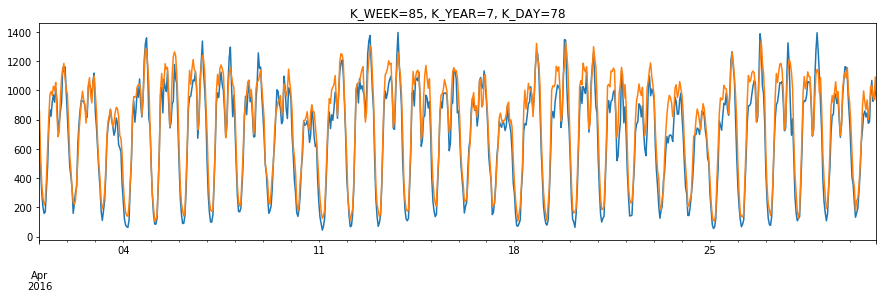

In [38]:
warnings.filterwarnings('ignore')
K_WEEK = 85
K_YEAR = 7
best_err = float('inf')
march_data = cell_data.loc[:datetime.datetime(2016, 3, 31, 23)]
apr_data = cell_data.loc[datetime.datetime(2016, 4, 1, 0):datetime.datetime(2016, 4, 30, 23)]
train_labels = np.array(march_data['trips'])
test_labels = np.array(apr_data['trips'])
for i in range(1, 101):
    print(i, '/', 100)
    k_day = i
    features = new_add_trig_features(march_data, K_WEEK, K_YEAR, k_day)
    train_data = np.array(march_data[features])
    _ = new_add_trig_features(apr_data, K_WEEK, K_YEAR, k_day, counter=train_data.shape[0]+1)
    test_data = np.array(apr_data[features])
    model = linear_model.LinearRegression()
    try:
        model.fit(train_data, train_labels)
    except np.linalg.LinAlgError or np.linalg.linalg.LinAlgError:
        continue
    pred = model.predict(test_data)
    err = metrics.mean_absolute_error(test_labels, pred)
    if err < best_err:
        best_err = err
        best_k_day = k_day
        apr_data['pred'] = pred

fig, ax = plt.subplots(figsize=(15,4))
apr_data['trips'].plot(ax=ax)
apr_data['pred'].plot(ax=ax)
ax.set_title('K_WEEK={}, K_YEAR={}, K_DAY={}'.format(K_WEEK, K_YEAR, best_k_day, fontsize=20, y=1.01))
plt.show()
warnings.filterwarnings('default')

In [20]:
# Загружаем данные.
data = pd.read_csv('all_count.csv', sep=',', header=0, parse_dates=True,
                   date_parser = lambda x: datetime.datetime.strptime(x, '%Y-%m-%d %H:%M:%S'))
col_names = [datetime.datetime.strptime(i, '%Y-%m-%d %H:%M:%S') for i in data.columns[5:]]
col_names = list(data.columns[:5]) + col_names
data.columns = col_names 
all_count_into = pd.read_csv('all_count_into.csv', sep=',', header=0)
all_count_into.columns = col_names
pass_count = pd.read_csv('pass_count.csv', sep=',', header=0)
pass_count.columns = col_names
pass_count_into = pd.read_csv('pass_count_into.csv', sep=',', header=0)
pass_count_into.columns = col_names
dist_count = pd.read_csv('dist_count.csv', sep=',', header=0)
dist_count.columns = col_names
dist_count_into = pd.read_csv('dist_count_into.csv', sep=',', header=0)
dist_count_into.columns = col_names
reg_info = pd.read_csv('reg_info.csv', sep=',', header=0)
weather = pd.read_csv('weather.csv', sep=',', header=0, index_col=0, parse_dates=[0],
                     date_parser=lambda x: datetime.datetime.strptime(x, '%Y-%m-%d %H:%M:%S'))
fitted_values = pd.read_csv('fitted_values.csv', sep=',', header=0)
K_WEEK = 85
K_YEAR = 5
K_TRIG_DAY = 78
K_DAY = 6
K_HOUR = 23

In [ ]:
# Формируем общую выборку.
warnings.filterwarnings('ignore')
raw_sample = None
k = 0
for region in reg_info.region:
    k += 1
    print('{}/102\t{}'.format(k, datetime.datetime.now().strftime('%H:%M')))
    cell_data = data[data.region==region].iloc[:, 5:].transpose()
    cell_data.columns = ['trips']
    real = []
    other = []
    
    other += get_cluster_features(cell_data, region)
    real += get_year(cell_data)
    other += get_date_features(cell_data)
    other += new_add_trig_features(cell_data, K_WEEK, K_YEAR, K_TRIG_DAY)
    real += get_hour_day_lags(cell_data, K_DAY, K_HOUR)
    real += get_past_sums(cell_data)
    real += get_square(cell_data, region)
    other += is_holiday(cell_data)
    real += get_days_after_holiday(cell_data)
    real += neighbors_trips(cell_data, region)
    real += trips_into(cell_data, region)
    real += passengers(cell_data, region)
    real += passengers_into(cell_data, region)
    real += distance(cell_data, region)
    real += distance_into(cell_data, region)
    w_real, w_other = get_weather_data(cell_data, weather)
    real += w_real
    other += w_other
    cell_data['region'] = region
    for i in range(1, 7):
        cell_data['label_{}'.format(i)] = cell_data['trips'].shift(-i)
    cell_data.dropna(inplace=True)
    if raw_sample is None:
        raw_sample = cell_data.copy(deep=True)
    else:
        raw_sample = pd.concat((raw_sample, cell_data))

features = real + other
dump(real, 'final_dumps/real.joblib')
dump(features, 'final_dumps/features.joblib')
features = None
cell_data = None
real = None
other = None

print('\nkaggle_ids')

regs = np.array(raw_sample.region)
dates = ['{}_{}'.format(j.strftime('%Y-%m-%d'), j.hour) for j in list(raw_sample.index)]
temp = []
for j in range(len(dates)):
    a = str(int(regs[j]))+'_'+dates[j]
    temp.append(a)
for i in range(1, 7):
    print('{}/6\t{}'.format(i, datetime.datetime.now().strftime('%H:%M')))
    vals = []
    for j in range(len(temp)):
        a = temp[j]+'_'+str(i)
        vals.append(a)
    vals = np.array(vals)
    raw_sample['kaggle_id_{}'.format(i)] = vals
raw_sample.to_csv('final_samples/raw_sample.csv', sep=',', header=True, index=True)
#print(raw_sample.shape)

1/102	02:44
2/102	02:44
3/102	02:45
4/102	02:45
5/102	02:45
6/102	02:45
7/102	02:45
8/102	02:46
9/102	02:46
10/102	02:46
11/102	02:46
12/102	02:46
13/102	02:47
14/102	02:47
15/102	02:47
16/102	02:47
17/102	02:48
18/102	02:48
19/102	02:48
20/102	02:48
21/102	02:49
22/102	02:49
23/102	02:49
24/102	02:49
25/102	02:50
26/102	02:50
27/102	02:50
28/102	02:50
29/102	02:51
30/102	02:51
31/102	02:51
32/102	02:52
33/102	02:52
34/102	02:52
35/102	02:52
36/102	02:53
37/102	02:53
38/102	02:53
39/102	02:54
40/102	02:54
41/102	02:54
42/102	02:55
43/102	02:55
44/102	02:55
45/102	02:56
46/102	02:56
47/102	02:57
48/102	02:57
49/102	02:57
50/102	02:58
51/102	02:58
52/102	02:59
53/102	02:59
54/102	02:59
55/102	03:00
56/102	03:00
57/102	03:01
58/102	03:01
59/102	03:01
60/102	03:02
61/102	03:02
62/102	03:03
63/102	03:03
64/102	03:04
65/102	03:04
66/102	03:05
67/102	03:05
68/102	03:05
69/102	03:06
70/102	03:06
71/102	03:07
72/102	03:07
73/102	03:08
74/102	03:08
75/102	03:09
76/102	03:09
77/102	03:10
78/102	0

In [ ]:
# Поделим выборки. Обучим StandartScaler на обучающих выборках и транформируем тестовые.
real = load('final_dumps/real.joblib')
features = load('final_dumps/features.joblib')
raw_sample = pd.read_csv('final_samples/raw_sample.csv', sep=',', header=0, index_col=0, parse_dates=[0], 
                         date_parser=lambda x: datetime.datetime.strptime(x, '%Y-%m-%d %H:%M:%S'))

# Для теста на мае.
train_data_may = raw_sample[raw_sample.index <= datetime.datetime(2016,4,30,17)]
test_data_may = raw_sample[(raw_sample.index >= datetime.datetime(2016,4,30,23)) & 
                           (raw_sample.index <= datetime.datetime(2016,5,31,17))]
raw_sample = None
scaler = StandardScaler()
scaler.fit(train_data_may[real])
vals_train = scaler.transform(train_data_may[real])
vals_test = scaler.transform(test_data_may[real])
for i in range(len(real)):
    train_data_may[real[i]] = vals_train[:, i]
    test_data_may[real[i]] = vals_test[:, i]
for i in range(1, 7):
    train_labels_may = np.array(train_data_may['label_{}'.format(i)])
    test_labels_may = np.array(test_data_may['label_{}'.format(i)])
    np.save('final_samples/train_labels_may_{}'.format(i), train_labels_may)
    np.save('final_samples/test_labels_may_{}'.format(i), test_labels_may)
train_data_may = np.array(train_data_may[features])
test_data_may = np.array(test_data_may[features])
np.save('final_samples/train_data_may', train_data_may)
np.save('final_samples/test_data_may', test_data_may)
train_data_may = None
test_data_may = None


# Для теста на июне.
raw_sample = pd.read_csv('final_samples/raw_sample.csv', sep=',', header=0, index_col=0, parse_dates=[0], 
                         date_parser=lambda x: datetime.datetime.strptime(x, '%Y-%m-%d %H:%M:%S'))
train_data_june = raw_sample[raw_sample.index <= datetime.datetime(2016,5,31,17)]
test_data_june = raw_sample[(raw_sample.index >= datetime.datetime(2016,5,31,23)) & 
                            (raw_sample.index <= datetime.datetime(2016,6,30,17))]
raw_sample = None

# Для каггла.
for i in range(1, 7):
    target_index = list(test_data_june['kaggle_id_{}'.format(i)])
    dump(target_index, 'final_samples/target_index_{}.joblib'.format(i))

scaler = StandardScaler()
scaler.fit(train_data_june[real])
vals_train = scaler.transform(train_data_june[real])
vals_test = scaler.transform(test_data_june[real])
for i in range(len(real)):
    train_data_june[real[i]] = vals_train[:, i]
    test_data_june[real[i]] = vals_test[:, i]
for i in range(1, 7):
    train_labels_june = np.array(train_data_june['label_{}'.format(i)])
    test_labels_june = np.array(test_data_june['label_{}'.format(i)])
    np.save('final_samples/train_labels_june_{}'.format(i), train_labels_june)
    np.save('final_samples/test_labels_june_{}'.format(i), test_labels_june)
dump(test_data_june.index, 'dumps/june_index.joblib')
train_data_june = np.array(train_data_june[features])
test_data_june = np.array(test_data_june[features])
np.save('final_samples/train_data_june', train_data_june)
np.save('final_samples/test_data_june', test_data_june)
train_data_june = None
test_data_june = None

###  Обучение на данных до апреля.

In [2]:
train_data = np.load('/home/artem/hard/temp/train_data_may.npy')
test_data = np.load('/home/artem/hard/temp/test_data_may.npy')

### Ridge.

In [5]:
alphas = [0.001, 0.01, 0.1, 0.5, 1, 10] + list(np.logspace(2, 3, 50))
len(alphas)

56

In [7]:
param_dict = dict()
for i in range(1, 7):
    param_dict[i] = dict()
    for alpha in alphas:
        param_dict[i][alpha] = None
if os.path.exists('/home/artem/hard/temp/ridge_param_dict.joblib'):
    param_dict = load('/home/artem/hard/temp/ridge_param_dict.joblib')
for i in range(1, 7):
    for j in range(len(alphas)):
        alpha = alphas[j]
        if param_dict[i][alpha] is not None:
            continue
        print('{},{}'.format(i, j+1))
        ridge_model = linear_model.Ridge(alpha=alpha)
        train_labels = np.load('/home/artem/hard/temp/train_labels_may_{}.npy'.format(i))
        test_labels = np.load('/home/artem/hard/temp/test_labels_may_{}.npy'.format(i))
        ridge_model.fit(train_data, train_labels)
        pred = ridge_model.predict(test_data)
        err = metrics.mean_absolute_error(test_labels, pred)
        print(err)
        param_dict[i][alpha] = err
        dump(param_dict, '/home/artem/hard/temp/ridge_param_dict.joblib')
    print('Region {} done'.format(i))

1,1
17.041973878652215
1,2
17.043174081285787
1,3
17.056578023825193
1,4
17.128258781683208
1,5
17.21372934731658
1,6
17.65777241913505
1,7
17.808298192954062
1,8
17.809152507123127
1,9
17.809963652254307
1,10
17.810734300071083
1,11
17.81146543318268
1,12
17.812159201108344
1,13
17.81281523248149
1,14
17.81343555595217
1,15
17.814022243098467
1,16
17.814577549528632
1,17
17.815101825059696
1,18
17.815595499263583
1,19
17.81606238067102
1,20
17.81650216257123
1,21
17.816916480353285
1,22
17.817305065097138
1,23
17.817668688908
1,24
17.81801128310999
1,25
17.818333233824266
1,26
17.81863888368819
1,27
17.818928009785232
1,28
17.819198743966197
1,29
17.81945314196147
1,30
17.81969104909878
1,31
17.819916297566937
1,32
17.820127640131208
1,33
17.820325567938905
1,34
17.820509037755393
1,35
17.820683361929653
1,36
17.820849263548688
1,37
17.82100469418325
1,38
17.82114745273735
1,39
17.82127940422881
1,40
17.821401950018675
1,41
17.821513376495222
1,42
17.821616706488197
1,43
17.8217159356

In [8]:
res = load('/home/artem/hard/temp/ridge_param_dict.joblib')
out = []
for i in range(1, 7):
    print('Region', i)
    now = []
    for j in res[i]:
        now.append((j, res[i][j]))
    now.sort(key=lambda x: x[1])
    for j in now:
        print('alpha', j[0], ': ', j[1])
    out.append(now[0][1])
    print()
print()
print('MAE: ', sum(out)/len(out))

Region 1
alpha 0.001 :  17.041973878652215
alpha 0.01 :  17.043174081285787
alpha 0.1 :  17.056578023825193
alpha 0.5 :  17.128258781683208
alpha 1 :  17.21372934731658
alpha 10 :  17.65777241913505
alpha 100.0 :  17.808298192954062
alpha 104.81131341546852 :  17.809152507123127
alpha 109.85411419875584 :  17.809963652254307
alpha 115.1395399326447 :  17.810734300071083
alpha 120.67926406393289 :  17.81146543318268
alpha 126.48552168552958 :  17.812159201108344
alpha 132.57113655901094 :  17.81281523248149
alpha 138.94954943731375 :  17.81343555595217
alpha 145.63484775012444 :  17.814022243098467
alpha 152.64179671752333 :  17.814577549528632
alpha 159.98587196060572 :  17.815101825059696
alpha 167.68329368110082 :  17.815595499263583
alpha 175.7510624854791 :  17.81606238067102
alpha 184.20699693267164 :  17.81650216257123
alpha 193.06977288832496 :  17.816916480353285
alpha 202.35896477251575 :  17.817305065097138
alpha 212.09508879201903 :  17.817668688908
alpha 222.29964825261956 

### Lasso.

In [9]:
alphas = [0.001, 0.01, 0.1, 0.5, 1, 10] + list(np.logspace(2, 3, 20))
len(alphas)

26

In [10]:
param_dict = dict()
for i in range(1, 7):
    param_dict[i] = dict()
    for alpha in alphas:
        param_dict[i][alpha] = None
if os.path.exists('/home/artem/hard/temp/lasso_param_dict.joblib'):
    param_dict = load('/home/artem/hard/temp/lasso_param_dict.joblib')
for i in range(1, 7):
    for j in range(len(alphas)):
        alpha = alphas[j]
        if param_dict[i][alpha] is not None:
            continue
        print('{},{}'.format(i, j+1))
        lasso_model = linear_model.Lasso(alpha=alpha)
        train_labels = np.load('/home/artem/hard/temp/train_labels_may_{}.npy'.format(i))
        test_labels = np.load('/home/artem/hard/temp/test_labels_may_{}.npy'.format(i))
        lasso_model.fit(train_data, train_labels)
        pred = lasso_model.predict(test_data)
        err = metrics.mean_absolute_error(test_labels, pred)
        print(err)
        param_dict[i][alpha] = err
        dump(param_dict, '/home/artem/hard/temp/lasso_param_dict.joblib')
    print('Region {} done'.format(i))

1,1


/home/artem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


17.829524346121183
1,2


/home/artem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


17.81278799693835
1,3


/home/artem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


17.687839507513804
1,4
17.66659178857309
1,5
17.90494982104289
1,6
20.63790653480988
1,7
71.43932010851519
1,8
79.90606352934279
1,9
89.46742899502715
1,10
100.36992356380031
1,11
112.7825809447417
1,12
126.86816069170084
1,13
142.83993319307118
1,14
160.93027804103164
1,15
177.66702701519978
1,16
177.66702701519978
1,17
177.66702701519978
1,18
177.66702701519978
1,19
177.66702701519978
1,20
177.66702701519978
1,21
177.66702701519978
1,22
177.66702701519978
1,23
177.66702701519978
1,24
177.66702701519978
1,25
177.66702701519978
1,26
177.66702701519978
Region 1 done
2,1


/home/artem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


21.628789503773387
2,2


/home/artem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


21.62096840346449
2,3


/home/artem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


21.349632668052017
2,4
20.953186890488023
2,5
20.81123595224181
2,6
23.0900012567141
2,7
72.97917433634115
2,8
81.27265488050575
2,9
90.79719973490865
2,10
101.59365124019075
2,11
113.72539674303466
2,12
127.52761003374398
2,13
143.19980938013543
2,14
160.97337435209963
2,15
177.63936550690931
2,16
177.63936550690931
2,17
177.63936550690931
2,18
177.63936550690931
2,19
177.63936550690931
2,20
177.63936550690931
2,21
177.63936550690931
2,22
177.63936550690931
2,23
177.63936550690931
2,24
177.63936550690931
2,25
177.63936550690931
2,26
177.63936550690931
Region 2 done
3,1


/home/artem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


22.983339978657792
3,2


/home/artem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


22.990175292317613
3,3


/home/artem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


22.678747120900002
3,4
22.128177398987383
3,5
21.90303373088101
3,6
23.685252099730103
3,7
72.95326728956212
3,8
81.24147490345227
3,9
90.76396856311477
3,10
101.56006786783263
3,11
113.69180406655244
3,12
127.49395577349894
3,13
143.1661260449467
3,14
160.93977596884037
3,15
177.60604686424477
3,16
177.60604686424477
3,17
177.60604686424477
3,18
177.60604686424477
3,19
177.60604686424477
3,20
177.60604686424477
3,21
177.60604686424477
3,22
177.60604686424477
3,23
177.60604686424477
3,24
177.60604686424477
3,25
177.60604686424477
3,26
177.60604686424477
Region 3 done
4,1


/home/artem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


23.800295589769902
4,2


/home/artem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


23.817958077726672
4,3


/home/artem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


23.435673099822406
4,4
22.77920366031491
4,5
22.27836694989729
4,6
23.953145585325153
4,7
72.9272125987352
4,8
81.21433785697606
4,9
90.73534838093586
4,10
101.53154758870879
4,11
113.66434989845324
4,12
127.46785787470957
4,13
143.14220092329674
4,14
160.91863316352345
4,15
177.59069129666133
4,16
177.59069129666133
4,17
177.59069129666133
4,18
177.59069129666133
4,19
177.59069129666133
4,20
177.59069129666133
4,21
177.59069129666133
4,22
177.59069129666133
4,23
177.59069129666133
4,24
177.59069129666133
4,25
177.59069129666133
4,26
177.59069129666133
Region 4 done
5,1


/home/artem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


24.19805333708988
5,2


/home/artem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


24.22701106689778
5,3


/home/artem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


23.774001300279277
5,4
23.105675367994994
5,5
22.612872402261246
5,6
23.980148612155027
5,7
72.90708832408026
5,8
81.19767335787735
5,9
90.71544549617498
5,10
101.51265838647946
5,11
113.64802184424997
5,12
127.45446922938768
5,13
143.13215881351158
5,14
160.91241261994045
5,15
177.59615535796854
5,16
177.59615535796854
5,17
177.59615535796854
5,18
177.59615535796854
5,19
177.59615535796854
5,20
177.59615535796854
5,21
177.59615535796854
5,22
177.59615535796854
5,23
177.59615535796854
5,24
177.59615535796854
5,25
177.59615535796854
5,26
177.59615535796854
Region 5 done
6,1


/home/artem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


24.40160441838643
6,2


/home/artem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


24.43230753024833
6,3


/home/artem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


23.95708287450551
6,4
23.22096499577643
6,5
22.709662118098947
6,6
24.00647871032438
6,7
72.89796873707712
6,8
81.187999605292
6,9
90.70462431580702
6,10
101.50295746248884
6,11
113.63977688165734
6,12
127.44799420842811
6,13
143.12814976290645
6,14
160.91226896441148
6,15
177.60875879826492
6,16
177.60875879826492
6,17
177.60875879826492
6,18
177.60875879826492
6,19
177.60875879826492
6,20
177.60875879826492
6,21
177.60875879826492
6,22
177.60875879826492
6,23
177.60875879826492
6,24
177.60875879826492
6,25
177.60875879826492
6,26
177.60875879826492
Region 6 done


In [11]:
res = load('/home/artem/hard/temp/lasso_param_dict.joblib')
out = []
for i in range(1, 7):
    print('Region', i)
    now = []
    for j in res[i]:
        now.append((j, res[i][j]))
    now.sort(key=lambda x: x[1])
    for j in now:
        print('alpha', j[0], ': ', j[1])
    out.append(now[0][1])
    print()
print()
print('MAE: ', sum(out)/len(out))

Region 1
alpha 0.5 :  17.66659178857309
alpha 0.1 :  17.687839507513804
alpha 0.01 :  17.81278799693835
alpha 0.001 :  17.829524346121183
alpha 1 :  17.90494982104289
alpha 10 :  20.63790653480988
alpha 100.0 :  71.43932010851519
alpha 112.88378916846895 :  79.90606352934279
alpha 127.42749857031335 :  89.46742899502715
alpha 143.8449888287663 :  100.36992356380031
alpha 162.3776739188721 :  112.7825809447417
alpha 183.29807108324357 :  126.86816069170084
alpha 206.913808111479 :  142.83993319307118
alpha 233.57214690901213 :  160.93027804103164
alpha 263.6650898730358 :  177.66702701519978
alpha 297.63514416313194 :  177.66702701519978
alpha 335.9818286283781 :  177.66702701519978
alpha 379.26901907322497 :  177.66702701519978
alpha 428.13323987193957 :  177.66702701519978
alpha 483.2930238571752 :  177.66702701519978
alpha 545.559478116852 :  177.66702701519978
alpha 615.8482110660267 :  177.66702701519978
alpha 695.1927961775606 :  177.66702701519978
alpha 784.7599703514607 :  177.6

### XGB.

In [2]:
train_data = np.load('/home/artem/hard/temp/train_data_may.npy')
test_data = np.load('/home/artem/hard/temp/test_data_may.npy')

In [16]:
xgb_params = {'learning_rate': [0.1, 1], 'n_estimators': [100, 125, 150], 
              'reg_alpha': [0.01, 0.1], 'reg_lambda': [0.01, 0.1]}
params = list(product(xgb_params['learning_rate'], xgb_params['n_estimators'], 
                      xgb_params['reg_alpha'], xgb_params['reg_lambda']))
len(params)

16

In [4]:
param_dict = dict()
for i in range(1, 7):
    param_dict[i] = dict()
    for param in params:
        param_dict[i][param] = None
if os.path.exists('/home/artem/hard/temp/param_dict.joblib'):
    param_dict = load('/home/artem/hard/temp/param_dict.joblib')
for i in range(1, 7):
    for j in range(len(params)):
        param = params[j]
        if param_dict[i][param] is not None:
            continue
        print('{},{}'.format(i, j+1))
        xgb_model = xgb.XGBRegressor(learning_rate=param[0], n_estimators=param[1], 
                                    reg_lambda=param[2], reg_alpha=param[3], n_jobs=-1)
        train_labels = np.load('/home/artem/hard/temp/train_labels_may_{}.npy'.format(i))
        test_labels = np.load('/home/artem/hard/temp/test_labels_may_{}.npy'.format(i))
        xgb_model.fit(train_data, train_labels)
        pred = xgb_model.predict(test_data)
        err = metrics.mean_absolute_error(test_labels, pred)
        print(err)
        param_dict[i][param] = err
        dump(param_dict, '/home/artem/hard/temp/param_dict.joblib')
    print('Region {} done'.format(i))

Region 1 done
Region 2 done
Region 3 done
Region 4 done
Region 5 done
6,15
[15:02:58] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
23.30772634343089
6,16
[15:23:28] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
23.30772063823731
Region 6 done


In [5]:
res = load('/home/artem/hard/temp/param_dict.joblib')
out = []
for i in range(1, 7):
    print('Region', i)
    now = []
    for j in res[i]:
        now.append((j, res[i][j]))
    now.sort(key=lambda x: x[1])
    for j in now:
        print('alpha', j[0], ': ', j[1])
    out.append(now[0][1])
    print()
print()
print('MAE: ', sum(out)/len(out))

Region 1
alpha (1, 125, 0.1, 0.1) :  17.198853885942597
alpha (1, 125, 0.1, 0.01) :  17.198855349573957
alpha (0.1, 125, 0.01, 0.1) :  17.368045884801838
alpha (0.1, 125, 0.01, 0.01) :  17.36804589230441
alpha (0.1, 125, 0.1, 0.01) :  17.36805578130867
alpha (0.1, 125, 0.1, 0.1) :  17.36805593357814
alpha (1, 100, 0.1, 0.1) :  17.423118668235656
alpha (1, 100, 0.1, 0.01) :  17.42311979569399
alpha (1, 125, 0.01, 0.1) :  17.463440727669546
alpha (1, 125, 0.01, 0.01) :  17.463441578167288
alpha (0.1, 100, 0.1, 0.01) :  17.720136461005783
alpha (0.1, 100, 0.1, 0.1) :  17.72013678934531
alpha (0.1, 100, 0.01, 0.01) :  17.720150854263096
alpha (0.1, 100, 0.01, 0.1) :  17.720150969810454
alpha (1, 100, 0.01, 0.1) :  17.72493358133536
alpha (1, 100, 0.01, 0.01) :  17.724933915136553

Region 2
alpha (0.1, 125, 0.1, 0.01) :  19.824000301563814
alpha (0.1, 125, 0.1, 0.1) :  19.824000493398128
alpha (0.1, 125, 0.01, 0.01) :  19.824077816598578
alpha (0.1, 125, 0.01, 0.1) :  19.824078117562575
alp

In [14]:
res = load('/home/artem/hard/temp/param_dict.joblib')
err = 0
for i in range(1, 7):
    print('Region', i, end=', ')
    now = []
    for j in res[i]:
        now.append((j, res[i][j]))
    now.sort(key=lambda x: x[1])
    print('params', now[0][0], ': ', now[0][1])
    err += now[0][1]
    dump(now[0][0], '/home/artem/hard/temp/params_{}.joblib'.format(i))
    print()
print()
print('MAE: ', err/6)

Region 1, params (1, 125, 0.1, 0.1) :  17.198853885942597

Region 2, params (0.1, 125, 0.1, 0.01) :  19.824000301563814

Region 3, params (0.1, 125, 0.1, 0.1) :  20.658962147855544

Region 4, params (0.1, 125, 0.01, 0.01) :  20.70413343680416

Region 5, params (0.1, 125, 0.1, 0.01) :  20.842750757309954

Region 6, params (0.1, 125, 0.01, 0.01) :  20.927179775196855


MAE:  20.025980050778823


Принимаем XGB.

In [2]:
real = load('/home/artem/hard/temp/real.joblib')
features = load('/home/artem/hard/temp/features.joblib')
# Для теста на июне.
raw_sample = pd.read_csv('/home/artem/hard/temp/raw_sample.csv', sep=',', header=0, index_col=0, parse_dates=[0], 
                         date_parser=lambda x: datetime.datetime.strptime(x, '%Y-%m-%d %H:%M:%S'))
train_data_june = raw_sample[raw_sample.index <= datetime.datetime(2016,5,31,17)]
test_data_june = raw_sample[(raw_sample.index >= datetime.datetime(2016,5,31,23)) & 
                            (raw_sample.index <= datetime.datetime(2016,6,30,17))]
raw_sample = None

# Для каггла.
for i in range(1, 7):
    target_index = list(test_data_june['kaggle_id_{}'.format(i)])
    dump(target_index, '/home/artem/hard/temp/target_index_{}.joblib'.format(i))

scaler = StandardScaler()
scaler.fit(train_data_june[real])
vals_train = scaler.transform(train_data_june[real])
vals_test = scaler.transform(test_data_june[real])
for i in range(len(real)):
    train_data_june[real[i]] = vals_train[:, i]
    test_data_june[real[i]] = vals_test[:, i]
for i in range(1, 7):
    train_labels_june = np.array(train_data_june['label_{}'.format(i)])
    test_labels_june = np.array(test_data_june['label_{}'.format(i)])
    np.save('/home/artem/hard/temp/train_labels_june_{}'.format(i), train_labels_june)
    np.save('/home/artem/hard/temp/test_labels_june_{}'.format(i), test_labels_june)
dump(test_data_june.index, '/home/artem/hard/temp/june_index.joblib')
train_data_june = np.array(train_data_june[features])
test_data_june = np.array(test_data_june[features])
np.save('/home/artem/hard/temp/train_data_june', train_data_june)
np.save('/home/artem/hard/temp/test_data_june', test_data_june)
train_data_june = None
test_data_june = None

/home/artem/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/home/artem/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
/home/artem/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.


In [4]:
train_data = np.load('/home/artem/hard/temp/train_data_june.npy')
test_data = np.load('/home/artem/hard/temp/test_data_june.npy')

In [5]:
kaggle_dict = {1: None, 2: None, 3: None, 4: None, 5: None, 6: None}
for i in range(1, 7):
    if os.path.exists('/home/artem/hard/temp/kaggle_dict.joblib'):
        kaggle_dict = load('/home/artem/hard/temp/kaggle_dict.joblib')
    if kaggle_dict[i] is not None:
        continue
    print(i)
    train_labels = np.load('/home/artem/hard/temp/train_labels_june_{}.npy'.format(i))
    test_labels = np.load('/home/artem/hard/temp/test_labels_june_{}.npy'.format(i))
    target_index = load('/home/artem/hard/temp/target_index_{}.joblib'.format(i))
    param = load('/home/artem/hard/temp/params_{}.joblib'.format(i))
    model = xgb.XGBRegressor(learning_rate=param[0], n_estimators=param[1], 
                                    reg_lambda=param[2], reg_alpha=param[3], n_jobs=4)  
    model.fit(train_data, train_labels)
    pred = model.predict(test_data).clip(min=0)
    
    out = []
    for j in range(len(target_index)):
        out.append('{},{}'.format(target_index[j], pred[j]))
    kaggle_dict[i] = ['\n'.join(out), metrics.mean_absolute_error(test_labels, pred)]
    dump(kaggle_dict, '/home/artem/hard/temp/kaggle_dict.joblib')

4
[09:52:53] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
5
[10:21:20] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
6
[10:49:54] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [6]:
ERR = 0
out = 'id,y'
kaggle_dict = load('/home/artem/hard/temp/kaggle_dict.joblib')
for i in kaggle_dict:
    ERR += kaggle_dict[i][1]
    out += '\n'
    out += kaggle_dict[i][0]

with open('kaggle_xgb_1.csv', 'w') as f:
    f.write(out)

ERR /= 6

In [8]:
ERR

18.850507000691575

In [9]:
%%bash
kaggle competitions submit -c yellowtaxi -f kaggle_xgb_1.csv -m week_6

Successfully submitted to Жёлтое такси

100%|██████████| 16.1M/16.1M [00:07<00:00, 2.22MB/s]


Ссылка на сабмишн.

https://www.kaggle.com/submissions/11631547/11631547.raw

Ошибка составила 18.85050.

## 6.9. Заключительная попытка. 

Уберем аномалии.

In [25]:
from bokeh.io import output_notebook, show
from bokeh.plotting import figure, gridplot
output_notebook()
from bokeh.models import HoverTool

Loading BokehJS ...

In [26]:
data = pd.read_csv('all_count.csv', sep=',', header=0, parse_dates=True,
                   date_parser = lambda x: datetime.datetime.strptime(x, '%Y-%m-%d %H:%M:%S'))
reg = 1075
d1 = data[data.region==reg].iloc[:, 14000:-3000].transpose()
d1.columns = ['trips']
d1.index = [datetime.datetime.strptime(i, '%Y-%m-%d %H:%M:%S') for i in d1.index]
d2 = data[data.region==reg].iloc[:, 5000:-12000].transpose()
d2.columns = ['trips']
d2.index = [datetime.datetime.strptime(i, '%Y-%m-%d %H:%M:%S') for i in d2.index]
fig1 = figure(x_axis_type="datetime", plot_width=900, plot_height=250)
line1 = fig1.line(x='index', y='trips', source=d1)
fig1.add_tools(HoverTool(tooltips=[('Date', '@index{%Y-%m-%d %H:%M}'), ('Факт. знач.', '@trips')], 
                               renderers=[line1], formatters={'index': 'datetime'}))
fig1.xaxis[0].formatter.days = '%Y-%m-%d'
fig2 = figure(x_axis_type="datetime", plot_width=900, plot_height=250)
line2 = fig2.line(x='index', y='trips', source=d2)
fig2.add_tools(HoverTool(tooltips=[('Date', '@index{%Y-%m-%d %H:%M}'), ('Факт. знач.', '@trips')], 
                               renderers=[line2], formatters={'index': 'datetime'}))
fig2.xaxis[0].formatter.days = '%Y-%m-%d'
show(gridplot([[fig1], [fig2]]))

Уберем данные с 2015-01-26 13:00 по 2015-01-28 07:00 и с 2016-01-22 16:00 по 2016-01-25 07:00.

In [38]:
# Загружаем данные.
data = pd.read_csv('all_count.csv', sep=',', header=0, parse_dates=True,
                   date_parser = lambda x: datetime.datetime.strptime(x, '%Y-%m-%d %H:%M:%S'))
col_names = [datetime.datetime.strptime(i, '%Y-%m-%d %H:%M:%S') for i in data.columns[5:]]
col_names = list(data.columns[:5]) + col_names
data.columns = col_names 
all_count_into = pd.read_csv('all_count_into.csv', sep=',', header=0)
all_count_into.columns = col_names
pass_count = pd.read_csv('pass_count.csv', sep=',', header=0)
pass_count.columns = col_names
pass_count_into = pd.read_csv('pass_count_into.csv', sep=',', header=0)
pass_count_into.columns = col_names
dist_count = pd.read_csv('dist_count.csv', sep=',', header=0)
dist_count.columns = col_names
dist_count_into = pd.read_csv('dist_count_into.csv', sep=',', header=0)
dist_count_into.columns = col_names
reg_info = pd.read_csv('reg_info.csv', sep=',', header=0)
weather = pd.read_csv('weather.csv', sep=',', header=0, index_col=0, parse_dates=[0],
                     date_parser=lambda x: datetime.datetime.strptime(x, '%Y-%m-%d %H:%M:%S'))
fitted_values = pd.read_csv('fitted_values.csv', sep=',', header=0)
K_WEEK = 85
K_YEAR = 5
K_TRIG_DAY = 78
K_DAY = 6
K_HOUR = 23

In [45]:
# Формируем общую выборку.
warnings.filterwarnings('ignore')
raw_sample = None
k = 0
for region in reg_info.region:
    k += 1
    print('{}/102\t{}'.format(k, datetime.datetime.now().strftime('%H:%M')))
    cell_data = data[data.region==region].iloc[:, 5:].transpose()
    cell_data.columns = ['trips']
    real = []
    other = []
    
    other += get_cluster_features(cell_data, region)
    real += get_year(cell_data)
    other += get_date_features(cell_data)
    other += new_add_trig_features(cell_data, K_WEEK, K_YEAR, K_TRIG_DAY)
    real += get_hour_day_lags(cell_data, K_DAY, K_HOUR)
    real += get_past_sums(cell_data)
    real += get_square(cell_data, region)
    other += is_holiday(cell_data)
    real += get_days_after_holiday(cell_data)
    real += neighbors_trips(cell_data, region)
    real += trips_into(cell_data, region)
    real += passengers(cell_data, region)
    real += passengers_into(cell_data, region)
    real += distance(cell_data, region)
    real += distance_into(cell_data, region)
    w_real, w_other = get_weather_data(cell_data, weather)
    real += w_real
    other += w_other
    cell_data['region'] = region
    for i in range(1, 7):
        cell_data['label_{}'.format(i)] = cell_data['trips'].shift(-i)
    cell_data.dropna(inplace=True)
    
    # Уберем данные с 2015-01-26 13:00 по 2015-01-28 07:00 и с 2016-01-22 16:00 по 2016-01-25 07:00.
    cell_data = cell_data[(cell_data.index < datetime.datetime(2015, 1, 26, 13)) |
                          ((cell_data.index > datetime.datetime(2015, 1, 28, 7)) & 
                           (cell_data.index < datetime.datetime(2016, 1, 22, 16))) |
                          (cell_data.index > datetime.datetime(2016, 1, 25, 7))]
    
    if raw_sample is None:
        raw_sample = cell_data.copy(deep=True)
    else:
        raw_sample = pd.concat((raw_sample, cell_data))
features = real + other
dump(real, '/home/artem/hard/temp/real.joblib')
dump(features, '/home/artem/hard/temp/features.joblib')
features = None
cell_data = None
real = None
other = None

print('\nkaggle_ids')

regs = np.array(raw_sample.region)
dates = ['{}_{}'.format(j.strftime('%Y-%m-%d'), j.hour) for j in list(raw_sample.index)]
temp = []
for j in range(len(dates)):
    a = str(int(regs[j]))+'_'+dates[j]
    temp.append(a)
for i in range(1, 7):
    print('{}/6\t{}'.format(i, datetime.datetime.now().strftime('%H:%M')))
    vals = []
    for j in range(len(temp)):
        a = temp[j]+'_'+str(i)
        vals.append(a)
    vals = np.array(vals)
    raw_sample['kaggle_id_{}'.format(i)] = vals
raw_sample.to_csv('/home/artem/hard/temp/raw_sample.csv', sep=',', header=True, index=True)
#print(raw_sample.shape)

1/102	20:14
2/102	20:14
3/102	20:14
4/102	20:14
5/102	20:14
6/102	20:14
7/102	20:15
8/102	20:15
9/102	20:15
10/102	20:15
11/102	20:15
12/102	20:16
13/102	20:16
14/102	20:16
15/102	20:16
16/102	20:17
17/102	20:17
18/102	20:17
19/102	20:17
20/102	20:17
21/102	20:18
22/102	20:18
23/102	20:18
24/102	20:18
25/102	20:19
26/102	20:19
27/102	20:19
28/102	20:19
29/102	20:20
30/102	20:20
31/102	20:20
32/102	20:21
33/102	20:21
34/102	20:21
35/102	20:21
36/102	20:22
37/102	20:22
38/102	20:22
39/102	20:23
40/102	20:23
41/102	20:23
42/102	20:24
43/102	20:24
44/102	20:24
45/102	20:25
46/102	20:25
47/102	20:25
48/102	20:26
49/102	20:26
50/102	20:26
51/102	20:27
52/102	20:27
53/102	20:28
54/102	20:28
55/102	20:28
56/102	20:29
57/102	20:29
58/102	20:30
59/102	20:30
60/102	20:30
61/102	20:31
62/102	20:31
63/102	20:32
64/102	20:32
65/102	20:32
66/102	20:33
67/102	20:33
68/102	20:34
69/102	20:34
70/102	20:35
71/102	20:35
72/102	20:36
73/102	20:36
74/102	20:37
75/102	20:37
76/102	20:37
77/102	20:38
78/102	2

In [46]:
real = load('/home/artem/hard/temp/real.joblib')
features = load('/home/artem/hard/temp/features.joblib')
# Для теста на июне.
raw_sample = pd.read_csv('/home/artem/hard/temp/raw_sample.csv', sep=',', header=0, index_col=0, parse_dates=[0], 
                         date_parser=lambda x: datetime.datetime.strptime(x, '%Y-%m-%d %H:%M:%S'))
train_data_june = raw_sample[raw_sample.index <= datetime.datetime(2016,5,31,17)]
test_data_june = raw_sample[(raw_sample.index >= datetime.datetime(2016,5,31,23)) & 
                            (raw_sample.index <= datetime.datetime(2016,6,30,17))]
raw_sample = None

# Для каггла.
for i in range(1, 7):
    target_index = list(test_data_june['kaggle_id_{}'.format(i)])
    dump(target_index, '/home/artem/hard/temp/target_index_{}.joblib'.format(i))

scaler = StandardScaler()
scaler.fit(train_data_june[real])
vals_train = scaler.transform(train_data_june[real])
vals_test = scaler.transform(test_data_june[real])
for i in range(len(real)):
    train_data_june[real[i]] = vals_train[:, i]
    test_data_june[real[i]] = vals_test[:, i]
for i in range(1, 7):
    train_labels_june = np.array(train_data_june['label_{}'.format(i)])
    test_labels_june = np.array(test_data_june['label_{}'.format(i)])
    np.save('/home/artem/hard/temp/train_labels_june_{}'.format(i), train_labels_june)
    np.save('/home/artem/hard/temp/test_labels_june_{}'.format(i), test_labels_june)
dump(test_data_june.index, '/home/artem/hard/temp/june_index.joblib')
train_data_june = np.array(train_data_june[features])
test_data_june = np.array(test_data_june[features])
np.save('/home/artem/hard/temp/train_data_june', train_data_june)
np.save('/home/artem/hard/temp/test_data_june', test_data_june)
train_data_june = None
test_data_june = None

In [2]:
train_data = np.load('/home/artem/hard/temp/train_data_june.npy')
test_data = np.load('/home/artem/hard/temp/test_data_june.npy')

In [3]:
kaggle_dict = {1: None, 2: None, 3: None, 4: None, 5: None, 6: None}
for i in range(1, 7):
    if os.path.exists('/home/artem/hard/temp/kaggle_dict.joblib'):
        kaggle_dict = load('/home/artem/hard/temp/kaggle_dict.joblib')
    if kaggle_dict[i] is not None:
        continue
    print(i)
    train_labels = np.load('/home/artem/hard/temp/train_labels_june_{}.npy'.format(i))
    test_labels = np.load('/home/artem/hard/temp/test_labels_june_{}.npy'.format(i))
    target_index = load('/home/artem/hard/temp/target_index_{}.joblib'.format(i))
    param = load('/home/artem/hard/temp/params_{}.joblib'.format(i))
    model = xgb.XGBRegressor(learning_rate=param[0], n_estimators=param[1], 
                                    reg_lambda=param[2], reg_alpha=param[3], n_jobs=4)  
    model.fit(train_data, train_labels)
    pred = model.predict(test_data).clip(min=0)
    
    out = []
    for j in range(len(target_index)):
        out.append('{},{}'.format(target_index[j], pred[j]))
    kaggle_dict[i] = ['\n'.join(out), metrics.mean_absolute_error(test_labels, pred)]
    dump(kaggle_dict, '/home/artem/hard/temp/kaggle_dict.joblib')

6
[01:11:34] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [4]:
ERR = 0
out = 'id,y'
kaggle_dict = load('/home/artem/hard/temp/kaggle_dict.joblib')
for i in kaggle_dict:
    ERR += kaggle_dict[i][1]
    out += '\n'
    out += kaggle_dict[i][0]

with open('kaggle_xgb_2.csv', 'w') as f:
    f.write(out)

ERR /= 6

In [7]:
ERR

18.745475530267573

In [6]:
%%bash
kaggle competitions submit -c yellowtaxi -f kaggle_xgb_2.csv -m week_6

Successfully submitted to Жёлтое такси

100%|██████████| 16.2M/16.2M [00:05<00:00, 3.31MB/s]


Ссылка на сабмишн.

https://www.kaggle.com/submissions/11634489/11634489.raw

Ошибка составила 18.74547.